<a href="https://colab.research.google.com/github/alu0101132945/TFG/blob/main/CollabLDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importamos la librerias necesarias para trabajar con el modelo

In [ ]:
%pip install pyldavis
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import nltk
import math
from wordcloud import WordCloud
import pyLDAvis.gensim
import gensim


#from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


import string

from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

import re

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

In [ ]:
  def tokenize_lowercase(text):
    stop_words = stopwords.words('spanish')

    #add punctuation char's to stopwords list
    stop_words += list(string.punctuation) # <-- contains !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

    #add integers
    stop_words += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    stop_words += ['xi','sra','sr.','consejero','consejera','legislatura','dirigida', 'presidente','vicepresidente']
    tokens = word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

In [ ]:
def remove_nums(text_object):
  no_nums = list(filter(lambda x: x.isalpha(), text_object))
  return no_nums

In [ ]:
def lemmatize_text(df_text):
    lemmatized =[]
    processed = []
    for w in df_text:
        lemmatized.append(lemmatizer.lemmatize(w))
        processed = list(filter(lambda x: x.isalpha(), lemmatized))

    return processed

Obtenemos los codigos de cada grupo parlamentaria del campo id_organo_id

In [ ]:
# guardamos la URL con la info de los grupos
url = "https://parcan.es/api/informacion_grupos/11/"

# Hacemos una petición GET a la API
grupos_resp = requests.get(url)

# Intentar cargar el contenido como JSON
try:
    grupos_json = grupos_resp.json()
    grupos = grupos_json.get('result')

    # Si la carga es exitosa, procede con la extracción de los valores
    id_organo_ids = []

    # Itera sobre cada diccionario en la lista result
    for grupo in grupos:
      id_organo_id = grupo['id_organo_id']
      id_organo_ids.append(id_organo_id)

except json.JSONDecodeError:
    # Si no se puede cargar como JSON, probablemente sea una cadena
    print("El contenido de la respuesta no es un objeto JSON válido.")

generamos las urls para las iniciativas de cada grupo

In [ ]:
base_url = "https://parcan.es/api/informacion_grupos/iniciativas/{}"
urls = [base_url.format(code) for code in id_organo_ids]

Obtenemos los extractos de las iniciativas parlamentarias obtenidas de la API

In [ ]:
extractos = []
for ini_url in urls:
  iniciativas_resp = requests.get(ini_url)
  try:
    iniciativas_json = iniciativas_resp.json()
    iniciativas = iniciativas_json.get('result')
    for iniciativa in iniciativas:
      extracto = iniciativa['extracto']
      extractos.append(extracto)
  except json.JSONDecodeError:
    print("El contenido de la respuesta no es un objeto JSON válido.")
print(extractos)

Hacemos el preprocesamiento del texto de los extractos de las iniciativas parlamentarias

In [ ]:
extracto_token = []
for extracto in extractos:
  extracto = tokenize_lowercase(extracto)
  extracto = remove_nums(extracto)
  extracto = lemmatize_text(extracto)
  extracto_token.append(extracto)
print(extracto_token)

In [ ]:
palabras = [word for tokens in extracto_token for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

In [ ]:
k = 91
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(19,
  '0.278*"consejería" + 0.099*"fin" + 0.088*"implementarán" + 0.068*"posibles" + 0.042*"dependientes" + 0.038*"pleno" + 0.037*"gastos" + 0.037*"particular" + 0.030*"canarias" + 0.029*"infantiles"'),
 (35,
  '0.212*"denominado" + 0.166*"públicos" + 0.065*"primaria" + 0.053*"crecimiento" + 0.052*"abastecimiento" + 0.044*"agencia" + 0.044*"compra" + 0.034*"tributaria" + 0.032*"partidas" + 0.031*"acceder"'),
 (67,
  '0.103*"decreto" + 0.080*"calidad" + 0.059*"plazo" + 0.054*"procedimiento" + 0.052*"marzo" + 0.052*"prestaciones" + 0.048*"entrada" + 0.040*"jornada" + 0.040*"dependencia" + 0.036*"situación"'),
 (15,
  '0.257*"centros" + 0.122*"educativos" + 0.105*"objetivo" + 0.053*"alta" + 0.048*"alumnado" + 0.040*"posibilidad" + 0.035*"según" + 0.025*"2024" + 0.024*"cuentas" + 0.024*"sesión"'),
 (52,
  '0.202*"público" + 0.139*"2024" + 0.081*"pendientes" + 0.070*"febrero" + 0.059*"canarias" + 0.042*"reto" + 0.041*"declaraciones" + 0.039*"demográfico" + 0.032*"red" + 0.031*"existe"'),


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0             52              0.5944   
1            1             76              0.6267   
2            2             29              0.2526   
3            3             20              0.2526   
4            4             43              0.6021   
5            5              8              0.4301   
6            6             43              0.5017   
7            7             42              0.5013   
8            8              4              0.5567   
9            9             85              0.5013   

                                            Keywords  \
0  público, 2024, pendientes, febrero, canarias, ...   
1  fiscal, control, régimen, canarias, económico,...   
2  canario, servicio, salud, alumnos, resultados,...   
3  españa, proyectos, gobierno, promover, consejo...   
4  líneas, trabajo, estratégicas, va, santiago, l...   
5  energía, transición, ecológica, eólica, marina...   
6  líneas, trabajo, estratégicas, va, santiago, l...   
7  universidades, innovación, cultura, ciencia, c...   
8  agricultura, alimentaria, pesca, soberanía, ga...   
9  europea, unión, hacienda, relaciones, canarias...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Document_No'].plot(kind='hist', bins=20, title='Document_No')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Topic_Perc_Contrib'].plot(kind='hist', bins=20, title='Topic_Perc_Contrib')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Document_No', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Document_No', y='Topic_Perc_Contrib', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Topic_Perc_Contrib']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Topic_Perc_Contrib')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Document_No']
  ys = series['Topic_Perc_Contrib']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Document_No', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Document_No')
_ = plt.ylabel('Topic_Perc_Contrib')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Document_No']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Document_No'}, axis=1)
              .sort_values('Document_No', ascending=True))
  xs = counted['Document_No']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Document_No', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Document_No')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Document_No'].plot(kind='line', figsize=(8, 4), title='Document_No')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Topic_Perc_Contrib'].plot(kind='line', figsize=(8, 4), title='Topic_Perc_Contrib')
plt.gca().spines[['top', 'right']].set_visible(False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_ex

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


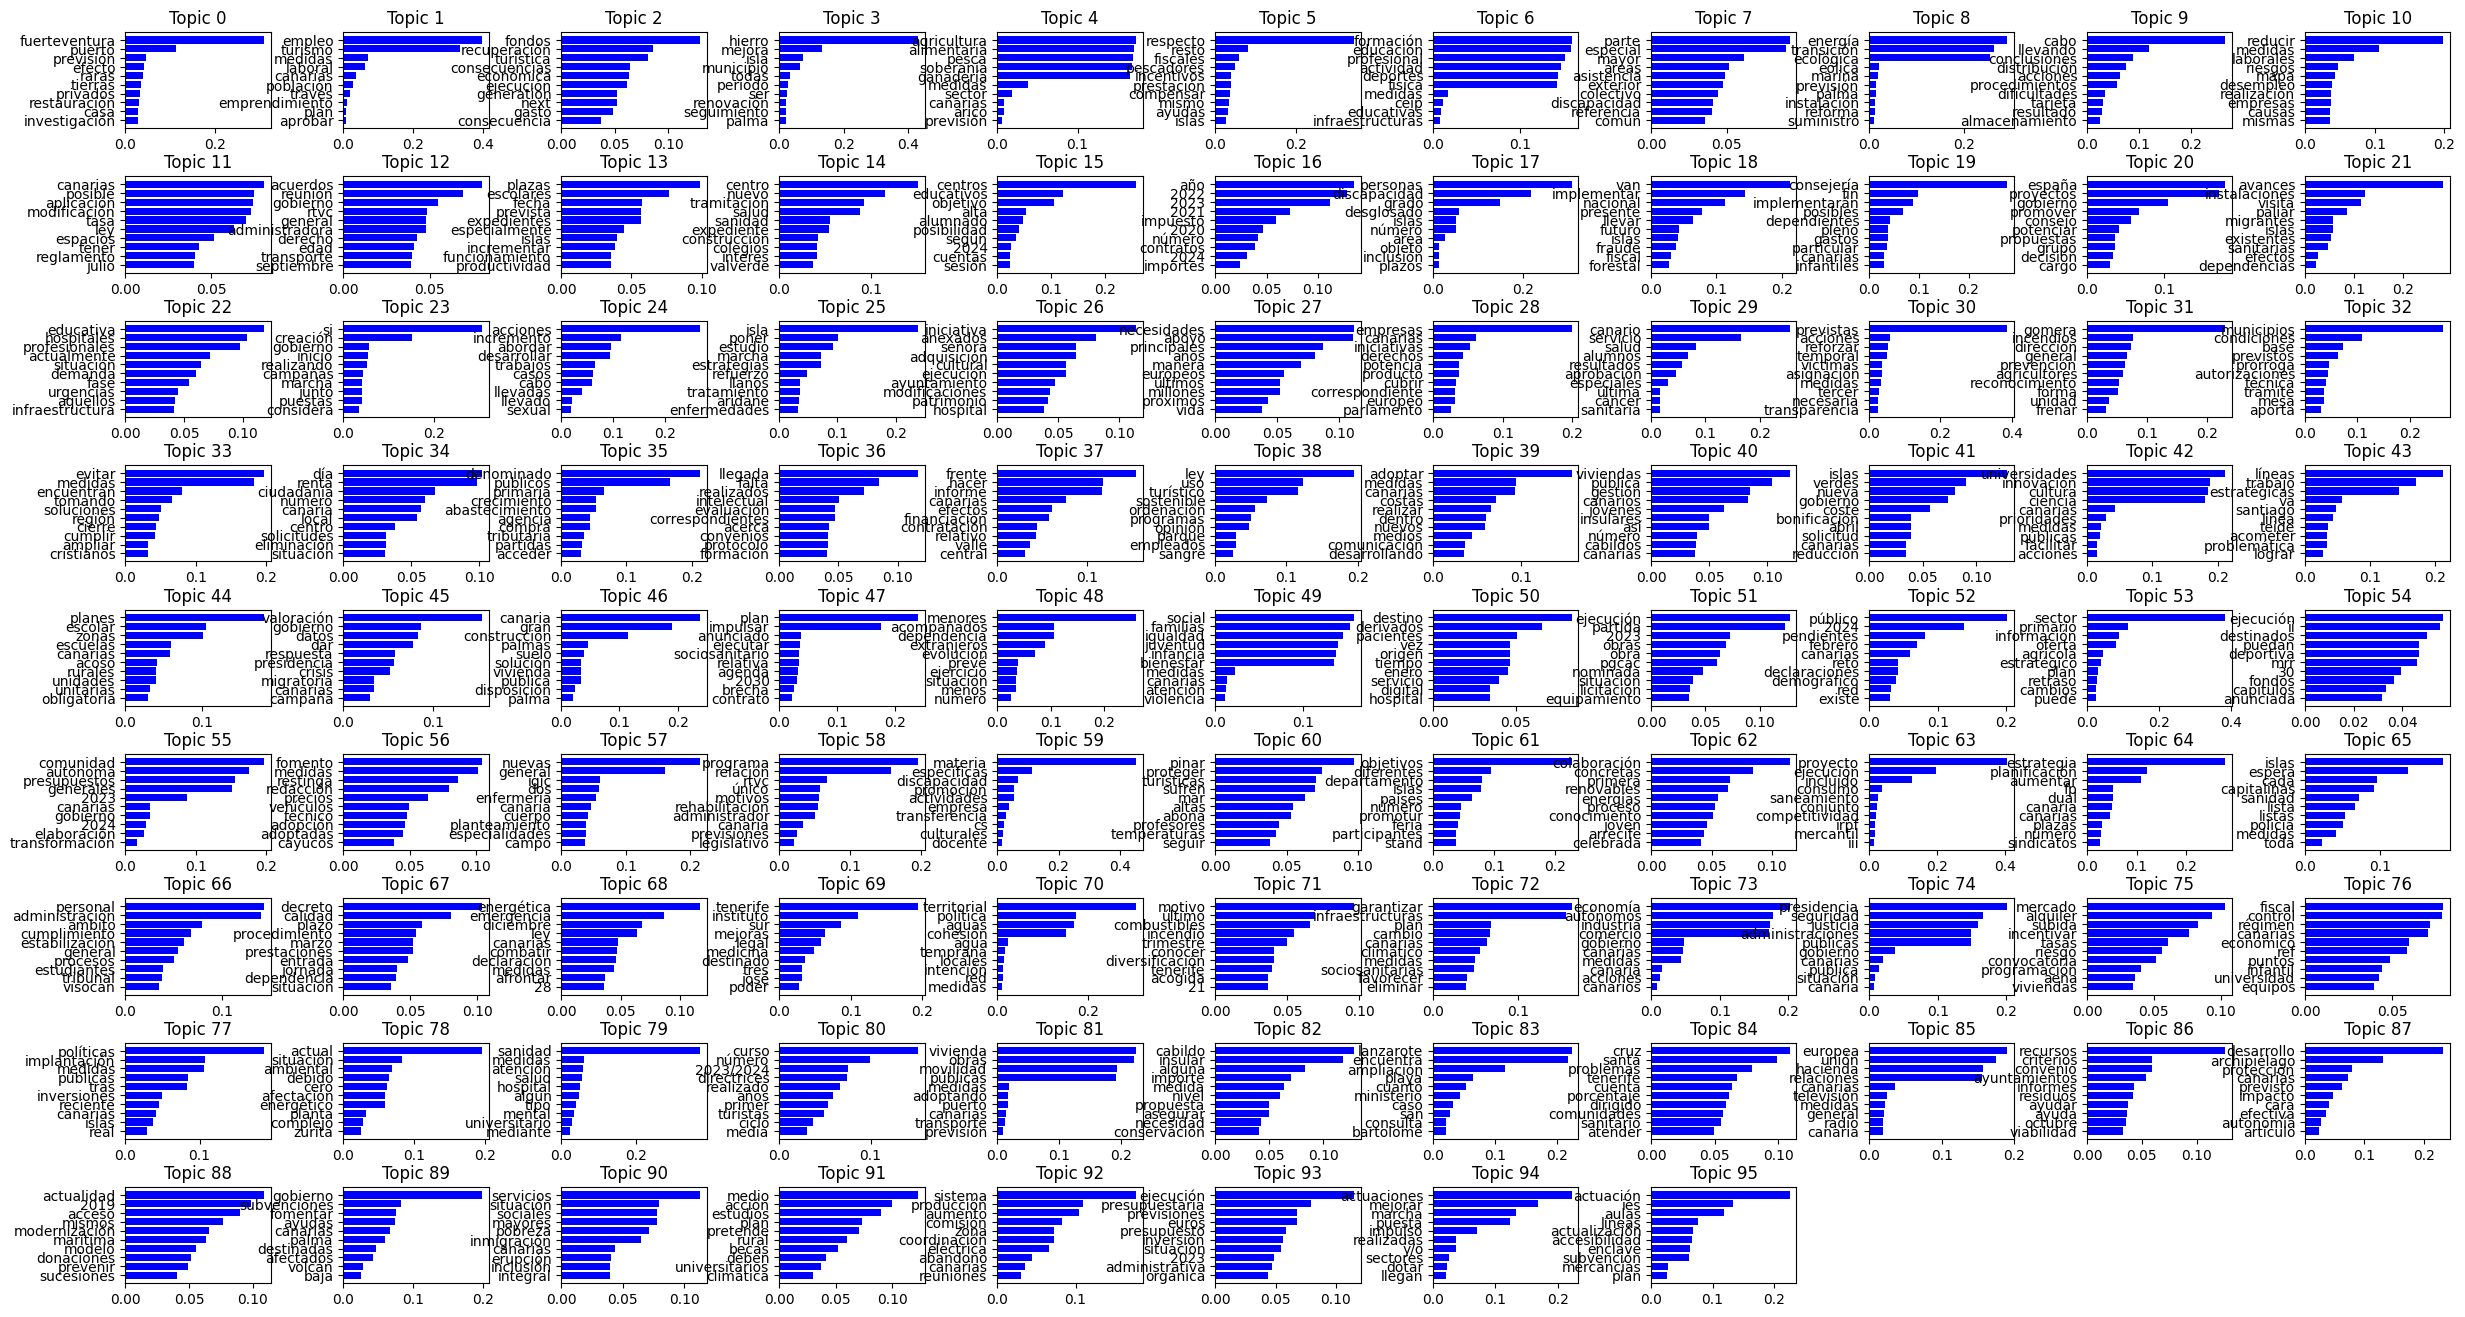

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Ahora obtenemos los extractos pero los separamos por cada grupo político

In [ ]:
extractos = {
    'extractos1': [],
    'extractos2': [],
    'extractos3': [],
    'extractos4': [],
    'extractos5': [],
    'extractos6': [],
    'extractos7': []
}
for i, ini_url in enumerate(urls):
    iniciativas_resp = requests.get(ini_url)
    try:
        iniciativas_json = iniciativas_resp.json()
        iniciativas = iniciativas_json.get('result')

        # Obtener el nombre de la variable de extractos
        nombre_variable = f'extractos{i+1}'

        # Obtener la lista de extractos correspondiente
        lista_extractos = extractos[nombre_variable]

        # Agregar extractos a la lista correspondiente
        for iniciativa in iniciativas:
            extracto = iniciativa['extracto']
            lista_extractos.append(extracto)

    except json.JSONDecodeError:
        print("El contenido de la respuesta no es un objeto JSON válido.")
for lista_extractos in extractos.values():
    # Extender la lista de todos_los_extractos con los extractos de la lista actual
    print(lista_extractos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['el reto demográfico y el equilibrio poblacional en Canarias.', 'la revisión del Régimen Económico y Fiscal de Canarias.', 'Consejo Canario de la Cultura.', 'Grupo Parlamentario Socialista Canario.', 'De la Sra. consejera de Sanidad, sobre las líneas estratégicas a desarrollar en la XI Legislatura.', 'Del Sr. consejero de Transición Ecológica y Energía, sobre las líneas estratégicas a desarrollar en la XI Legislatura.', 'De la Sra. consejera de Turismo y Empleo, sobre las líneas estratégicas a desarrollar en la XI Legislatura.', 'De la Sra. consejera de Universidades, Ciencia e Innovación y Cultura, sobre las líneas estratégicas a desarrollar en la XI Legislatura.', 'Del Sr. consejero de Agricultura, Ganadería, Pesca y Soberanía Alimentaria, sobre las líneas estratégicas a desarrollar en la XI Legislatura.', 'De la Sra. consejera de Hacienda y Relaciones con la Unión Europea, sobre las líneas estratégicas a desarrollar en la XI Legislatura.', 'De la Sra. consejera de Bienestar Social,

In [ ]:
extractos_token = {
    'extractos_token1': [],
    'extractos_token2': [],
    'extractos_token3': [],
    'extractos_token4': [],
    'extractos_token5': [],
    'extractos_token6': [],
    'extractos_token7': []
}
for i, extractos_text in enumerate(extractos.values()):
    for extrac in extractos_text:
      extractos_token[f'extractos_token{i+1}'].append(tokenize_lowercase(extrac))
    for extrac in extractos_text:
      extrac = remove_nums(extracto)
    for extrac in extractos_text:
      extrac = lemmatize_text(extracto)



for lista_extractos in extractos_token.values():
  # Extender la lista de todos_los_extractos con los extractos de la lista actual
  print(lista_extractos)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['reto', 'demográfico', 'equilibrio', 'poblacional', 'canarias'], ['revisión', 'régimen', 'económico', 'fiscal', 'canarias'], ['consejo', 'canario', 'cultura'], ['grupo', 'parlamentario', 'socialista', 'canario'], ['sanidad', 'líneas', 'estratégicas', 'desarrollar'], ['transición', 'ecológica', 'energía', 'líneas', 'estratégicas', 'desarrollar'], ['turismo', 'empleo', 'líneas', 'estratégicas', 'desarrollar'], ['universidades', 'ciencia', 'innovación', 'cultura', 'líneas', 'estratégicas', 'desarrollar'], ['agricultura', 'ganadería', 'pesca', 'soberanía', 'alimentaria', 'líneas', 'estratégicas', 'desarrollar'], ['hacienda', 'relaciones', 'unión', 'europea', 'líneas', 'estratégicas', 'desarrollar'], ['bienestar', 'social', 'igualdad', 'juventud', 'infancia', 'familias', 'líneas', 'estratégicas', 'desarrollar'], ['bienestar', 'social', 'igualdad', 'juventud', 'infancia', 'familias', 'líneas', 'estratégicas', 'desarrollar'], ['economía', 'industria', 'comercio', 'autónomos', 'líneas', 'est

Graficas del primer grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token1') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

23943 tokens total, with a vocabulary size of 4101
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


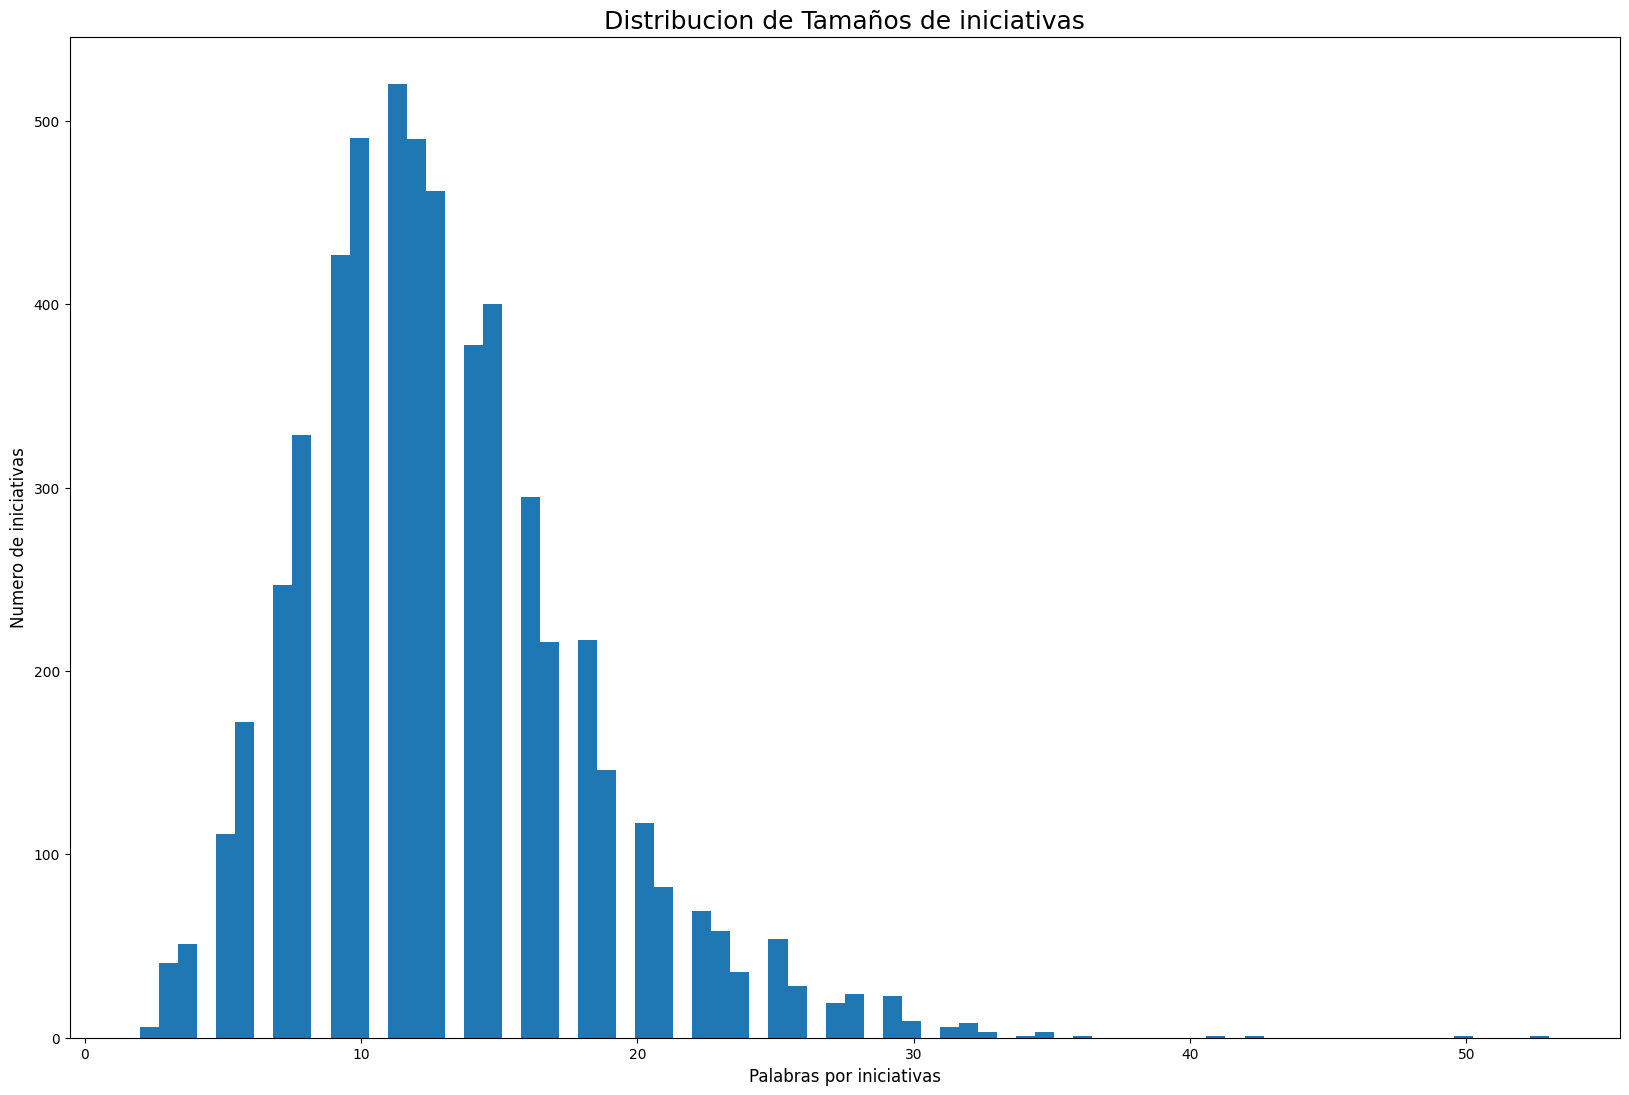

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


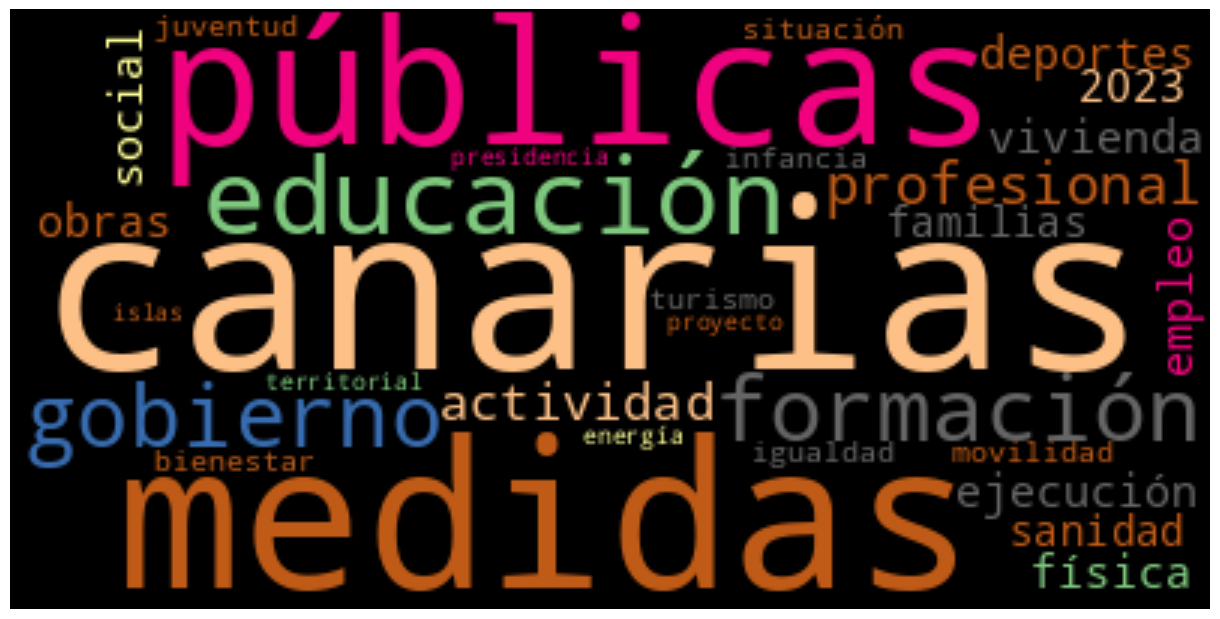

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


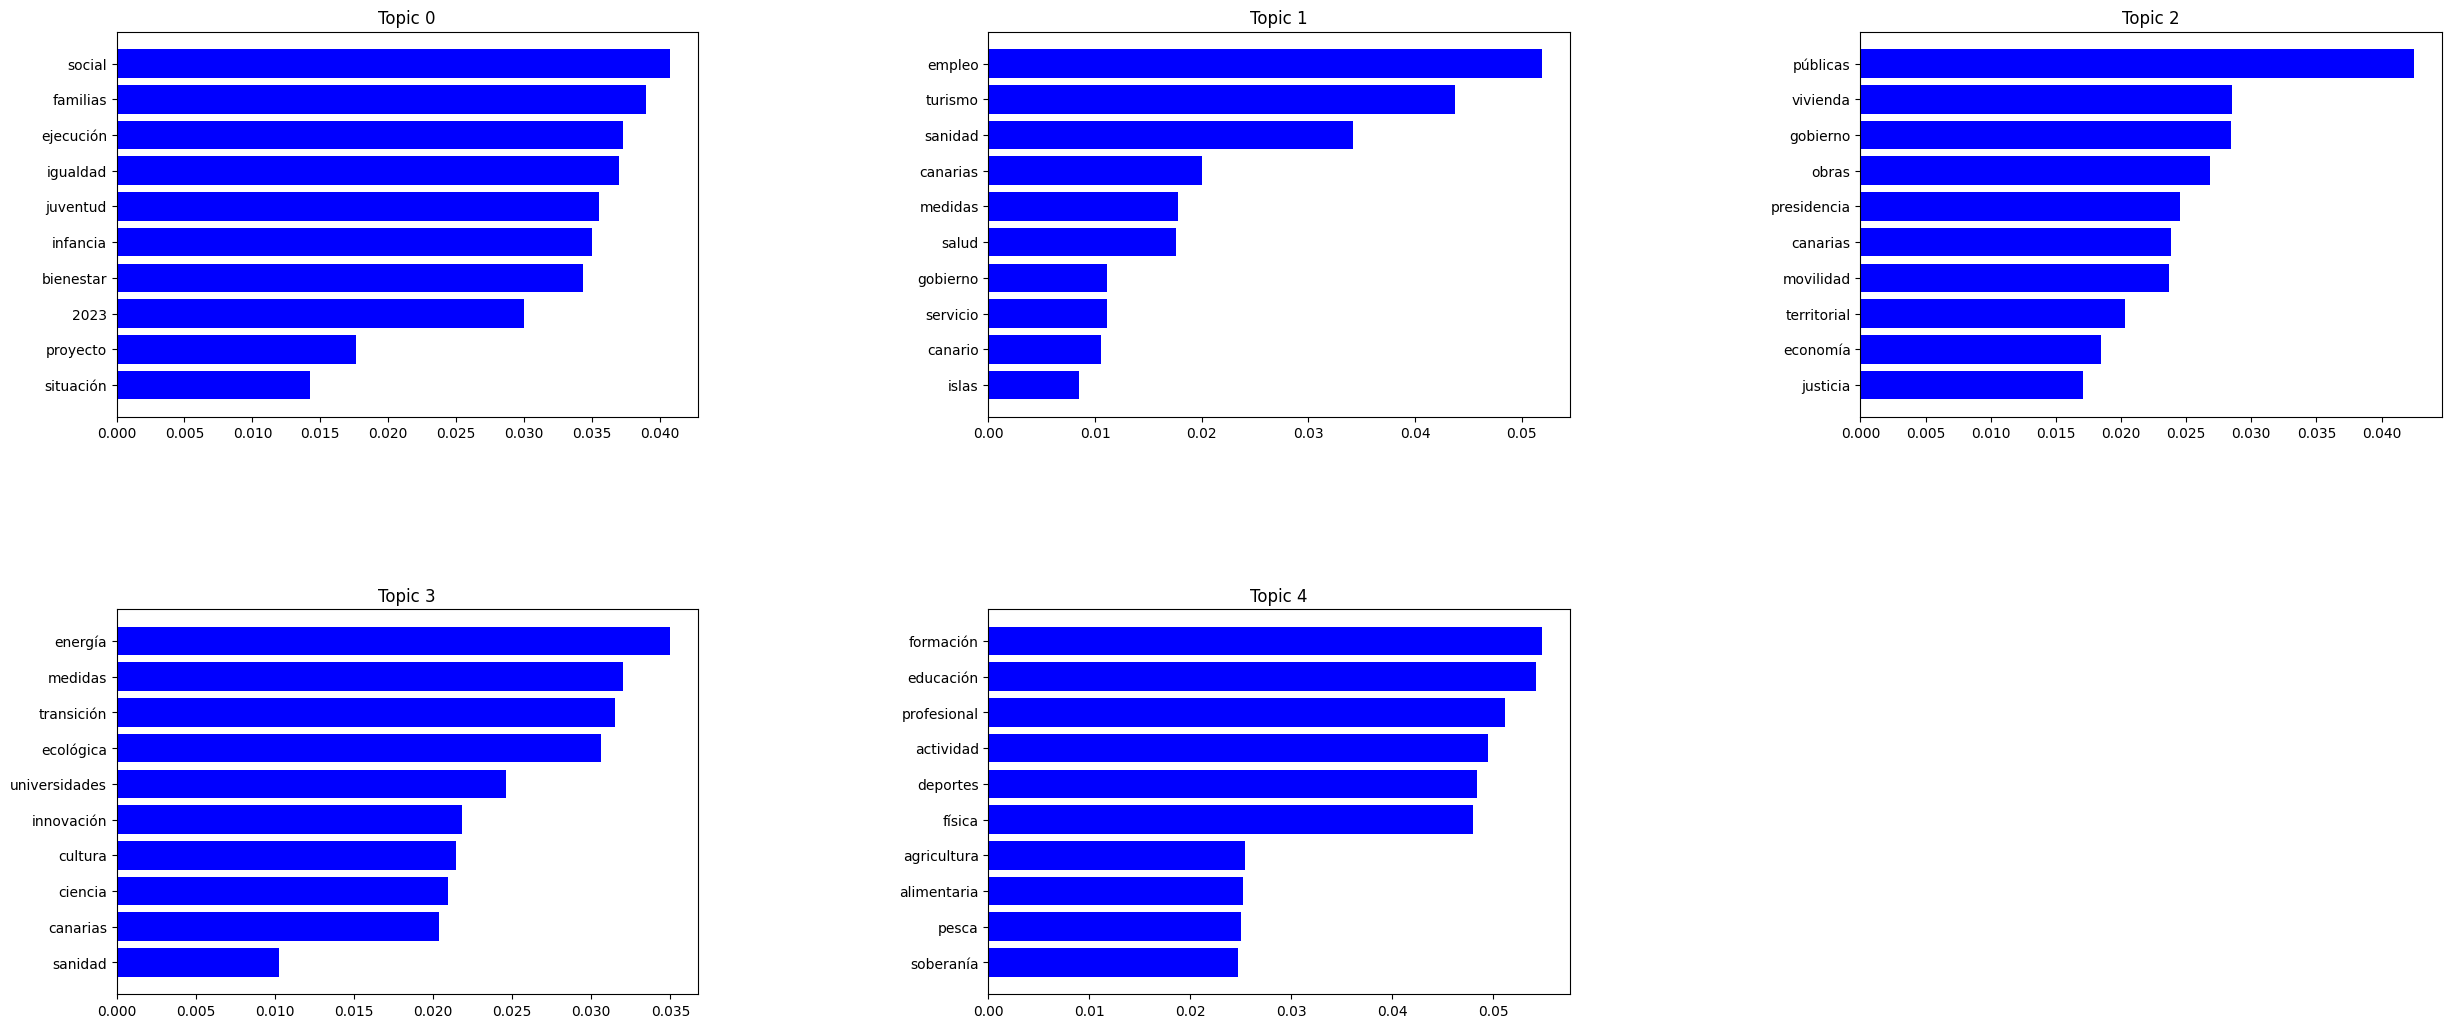

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Graficas del segundo grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token2') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

13210 tokens total, with a vocabulary size of 2655
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


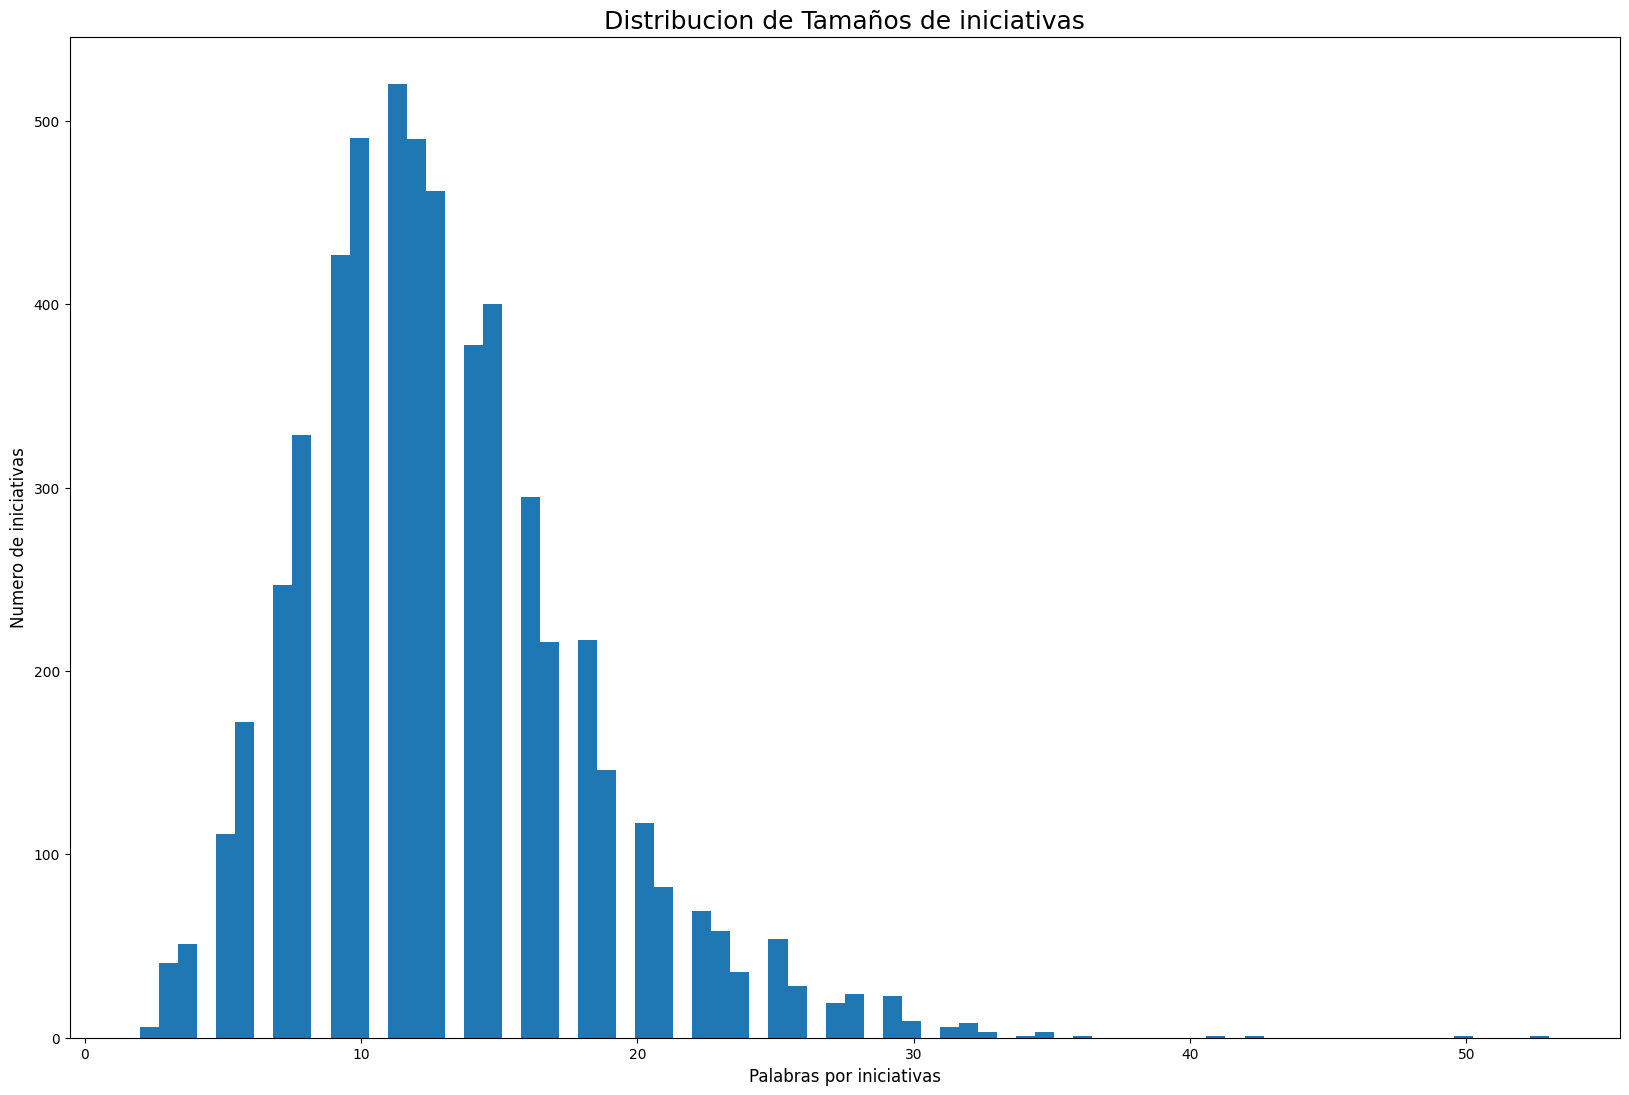

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


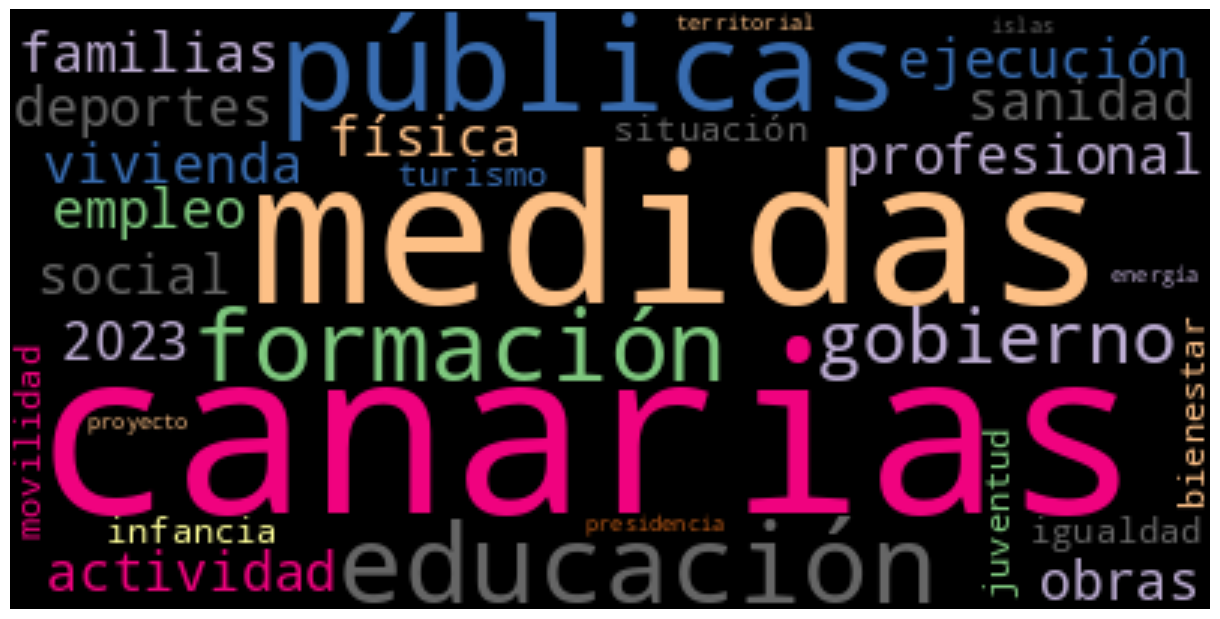

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


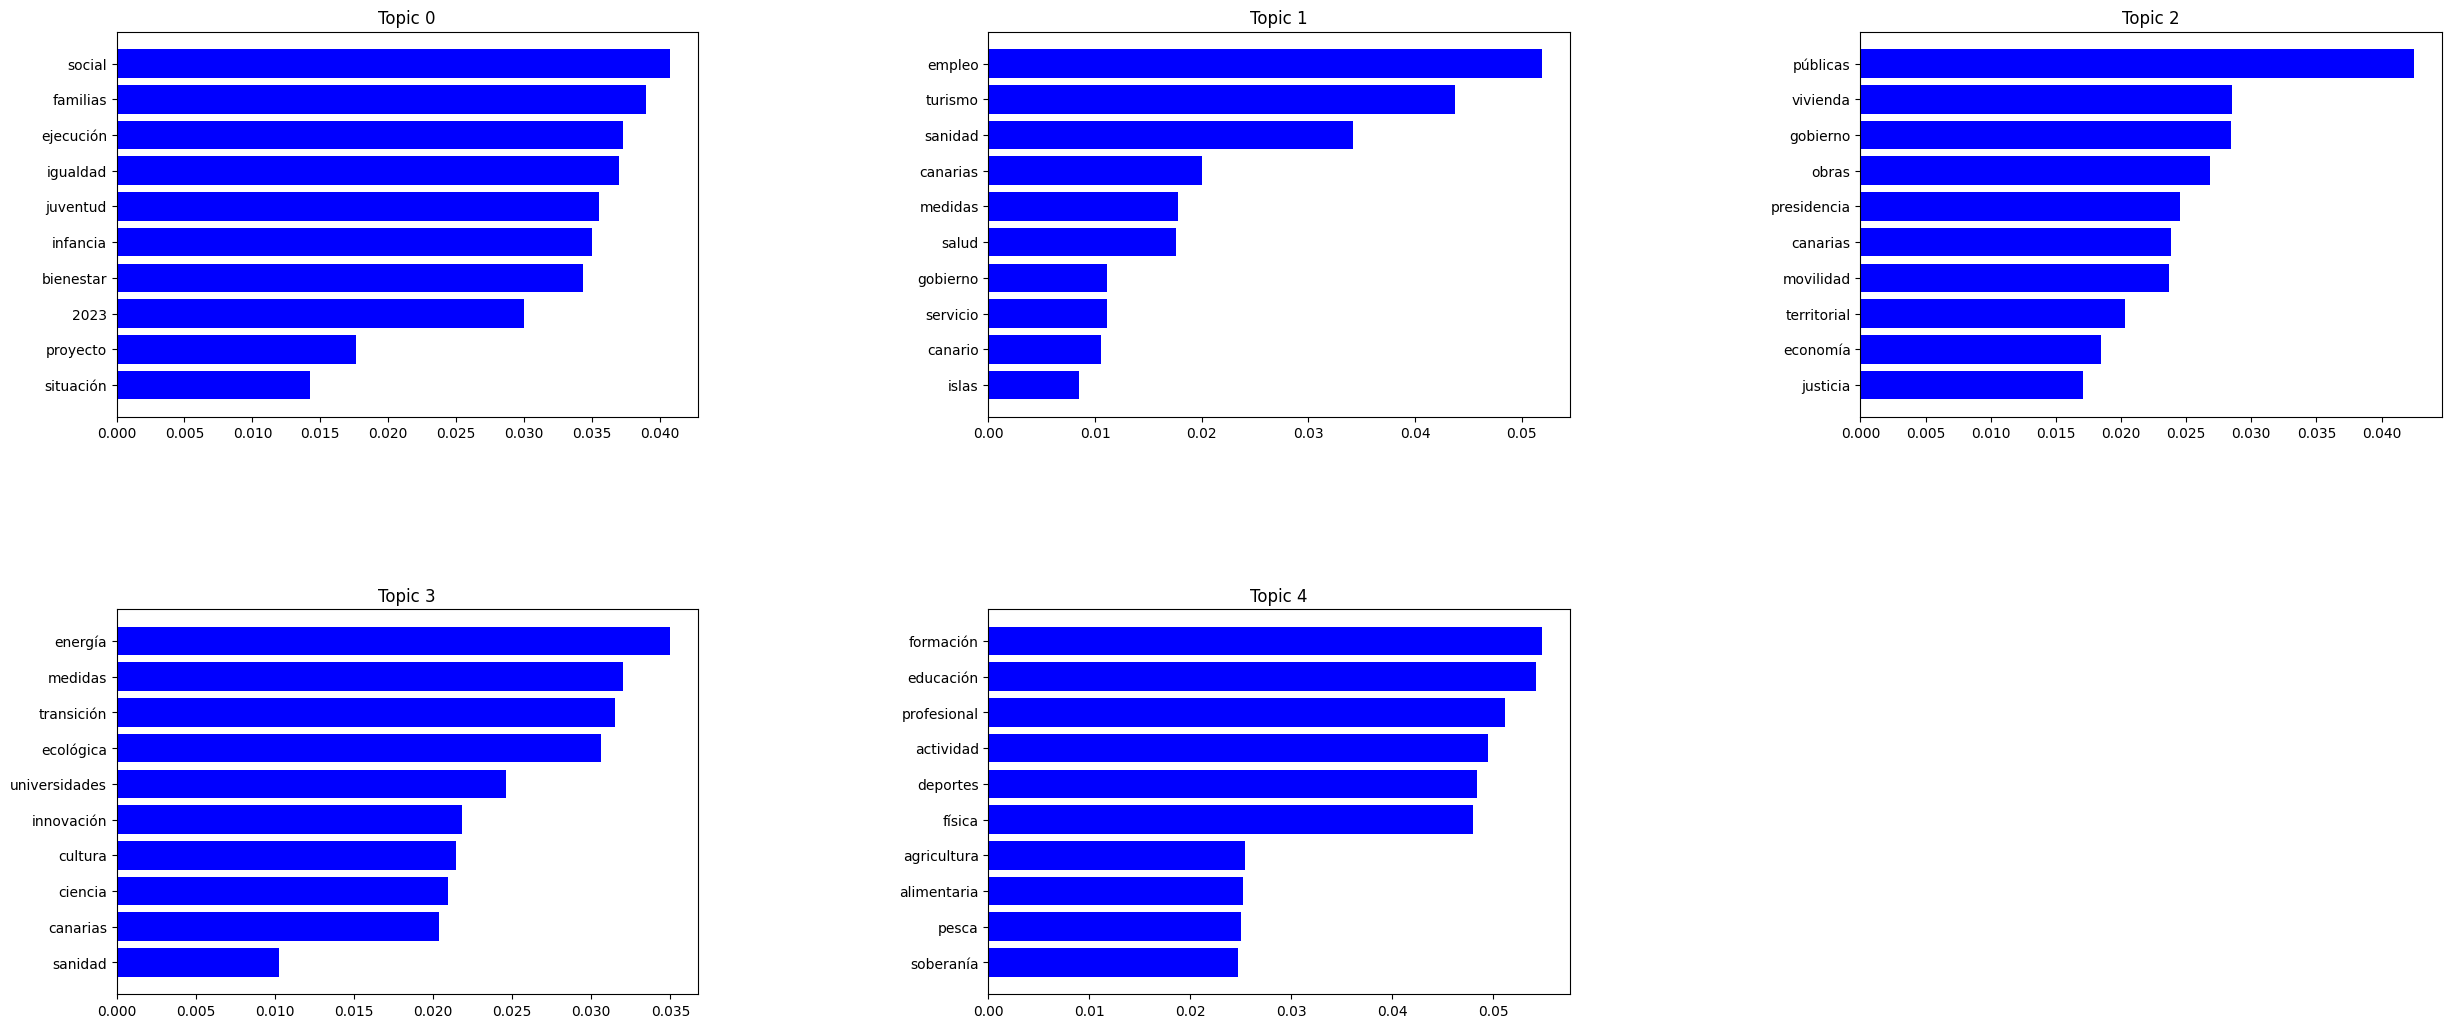

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Graficas del tercer grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token3') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

11553 tokens total, with a vocabulary size of 2534
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


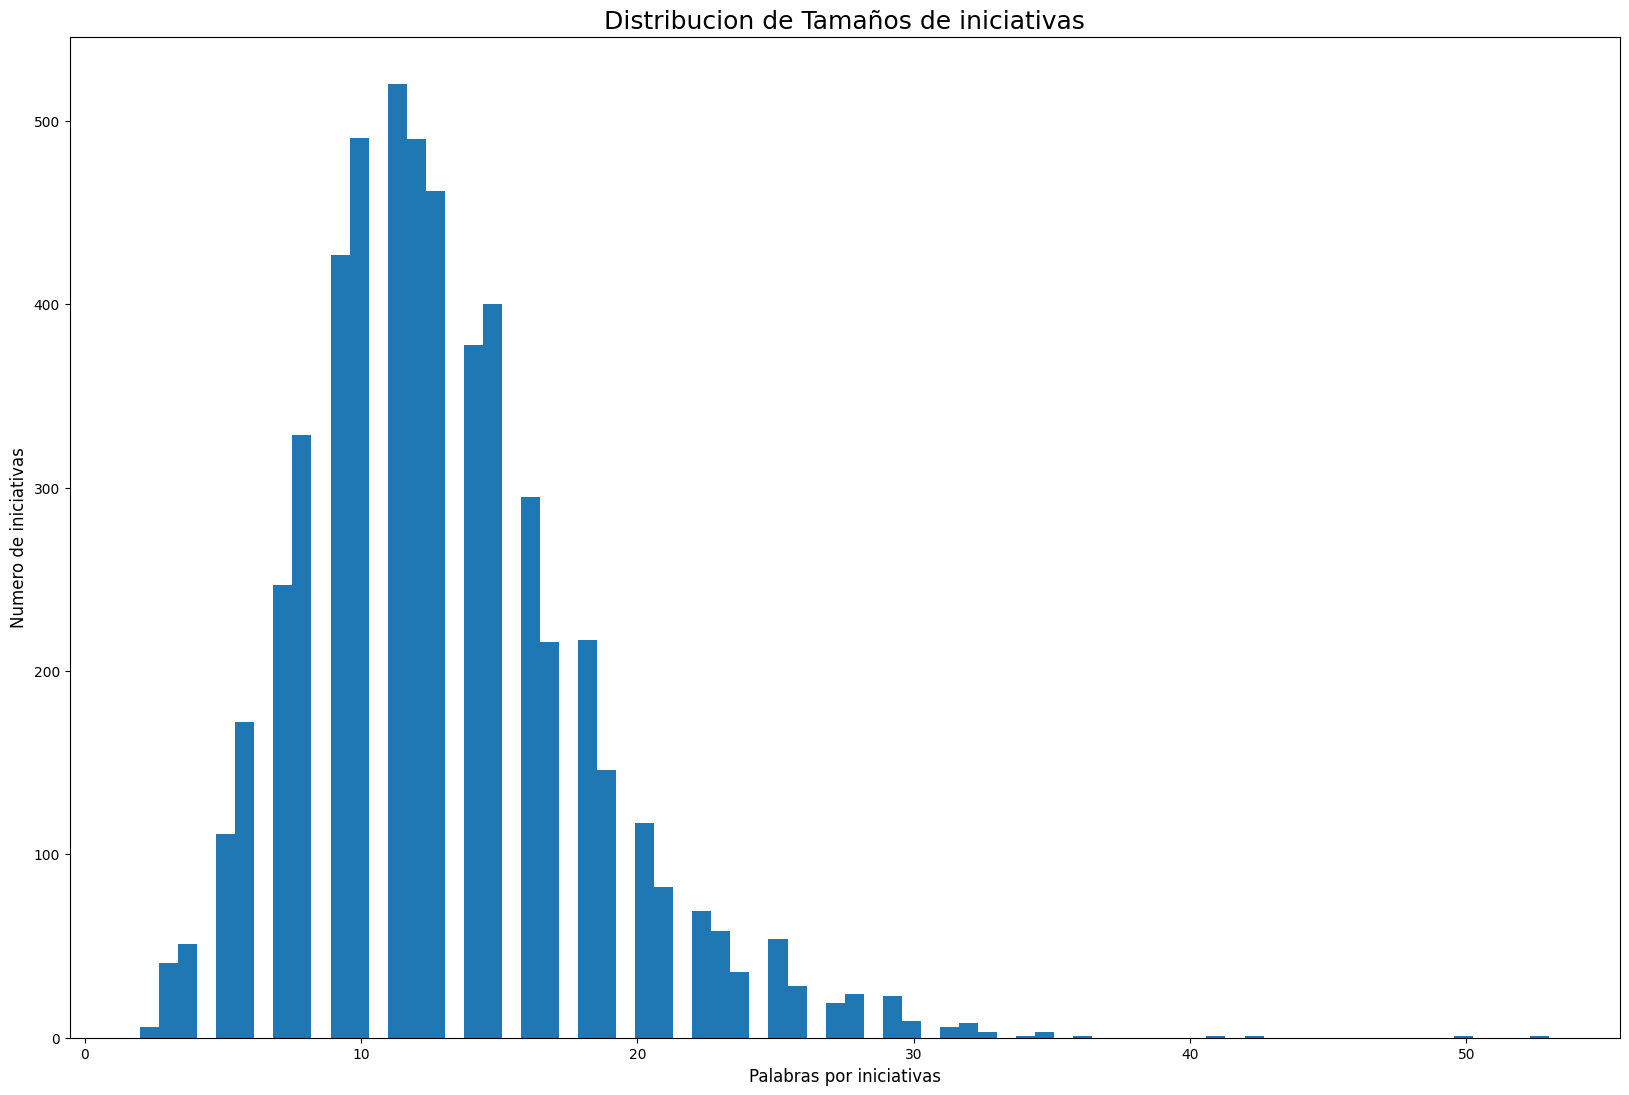

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


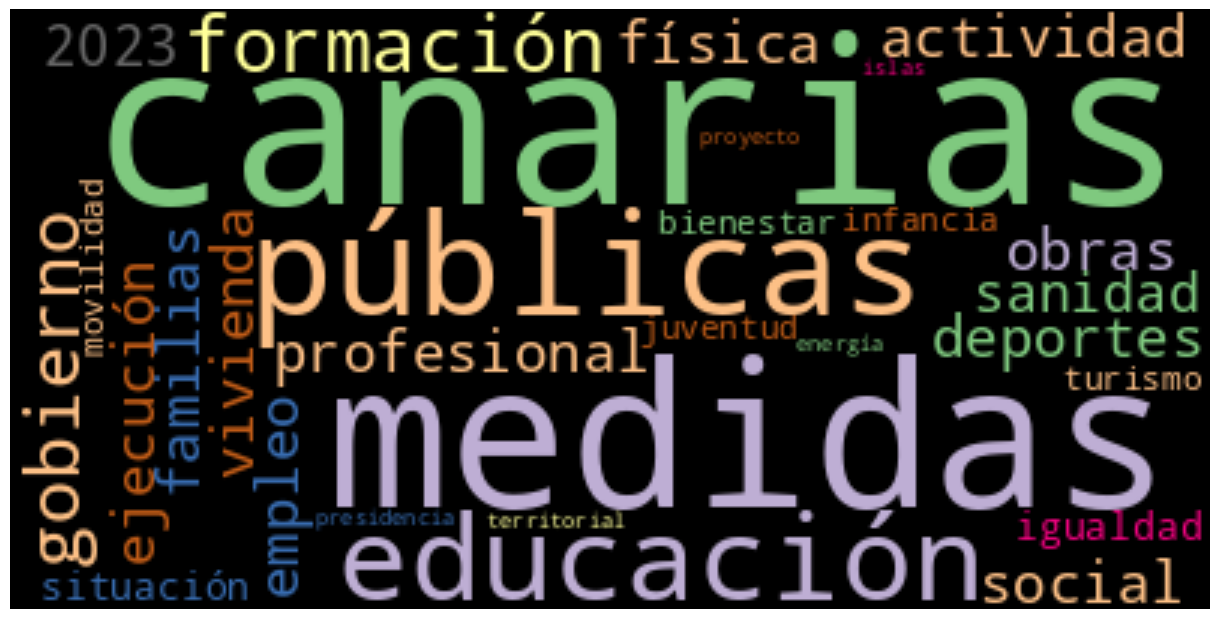

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


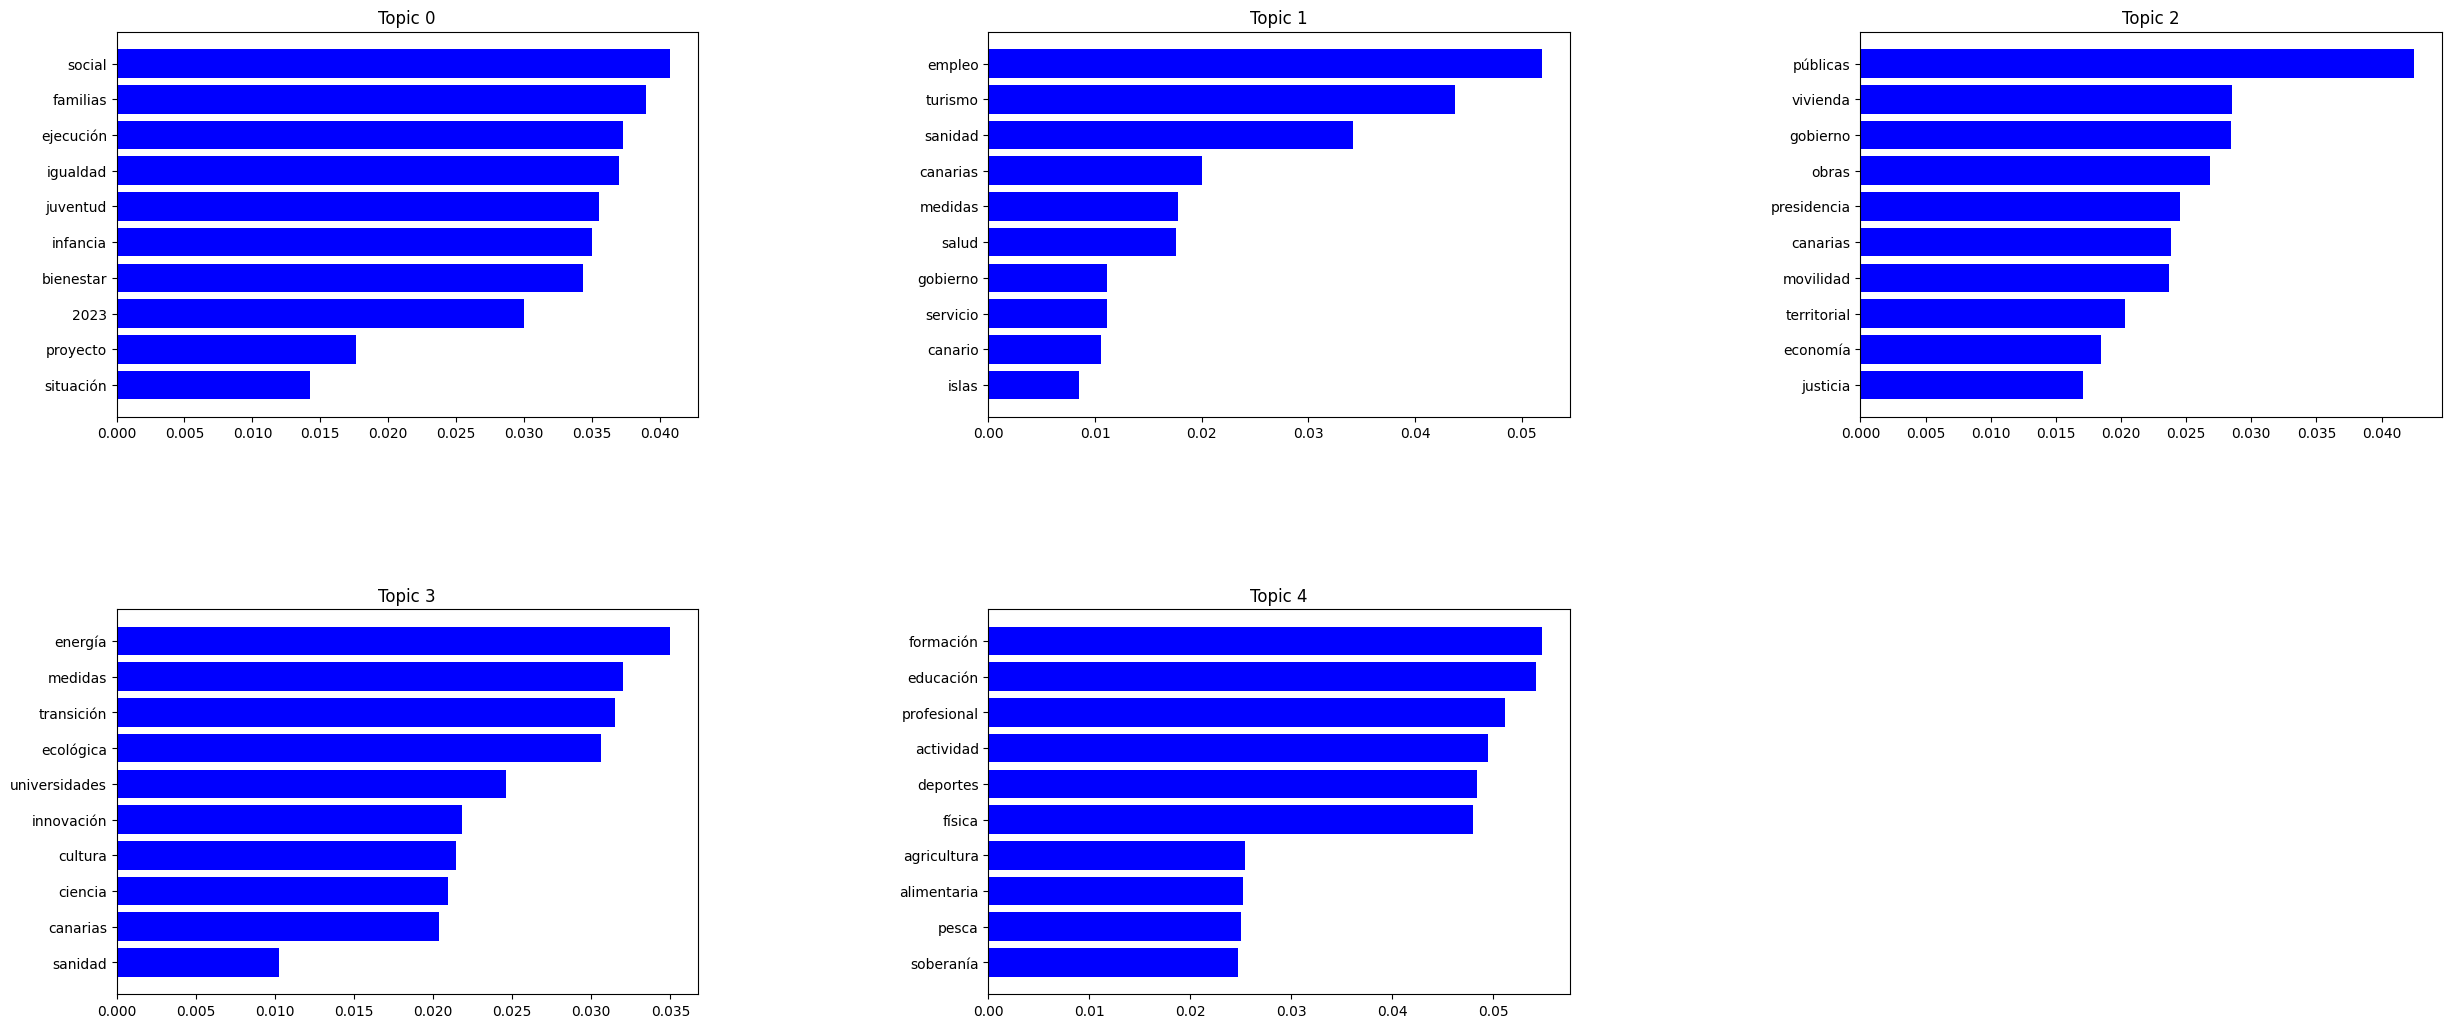

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Graficas del cuarto grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token4') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

4663 tokens total, with a vocabulary size of 1482
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


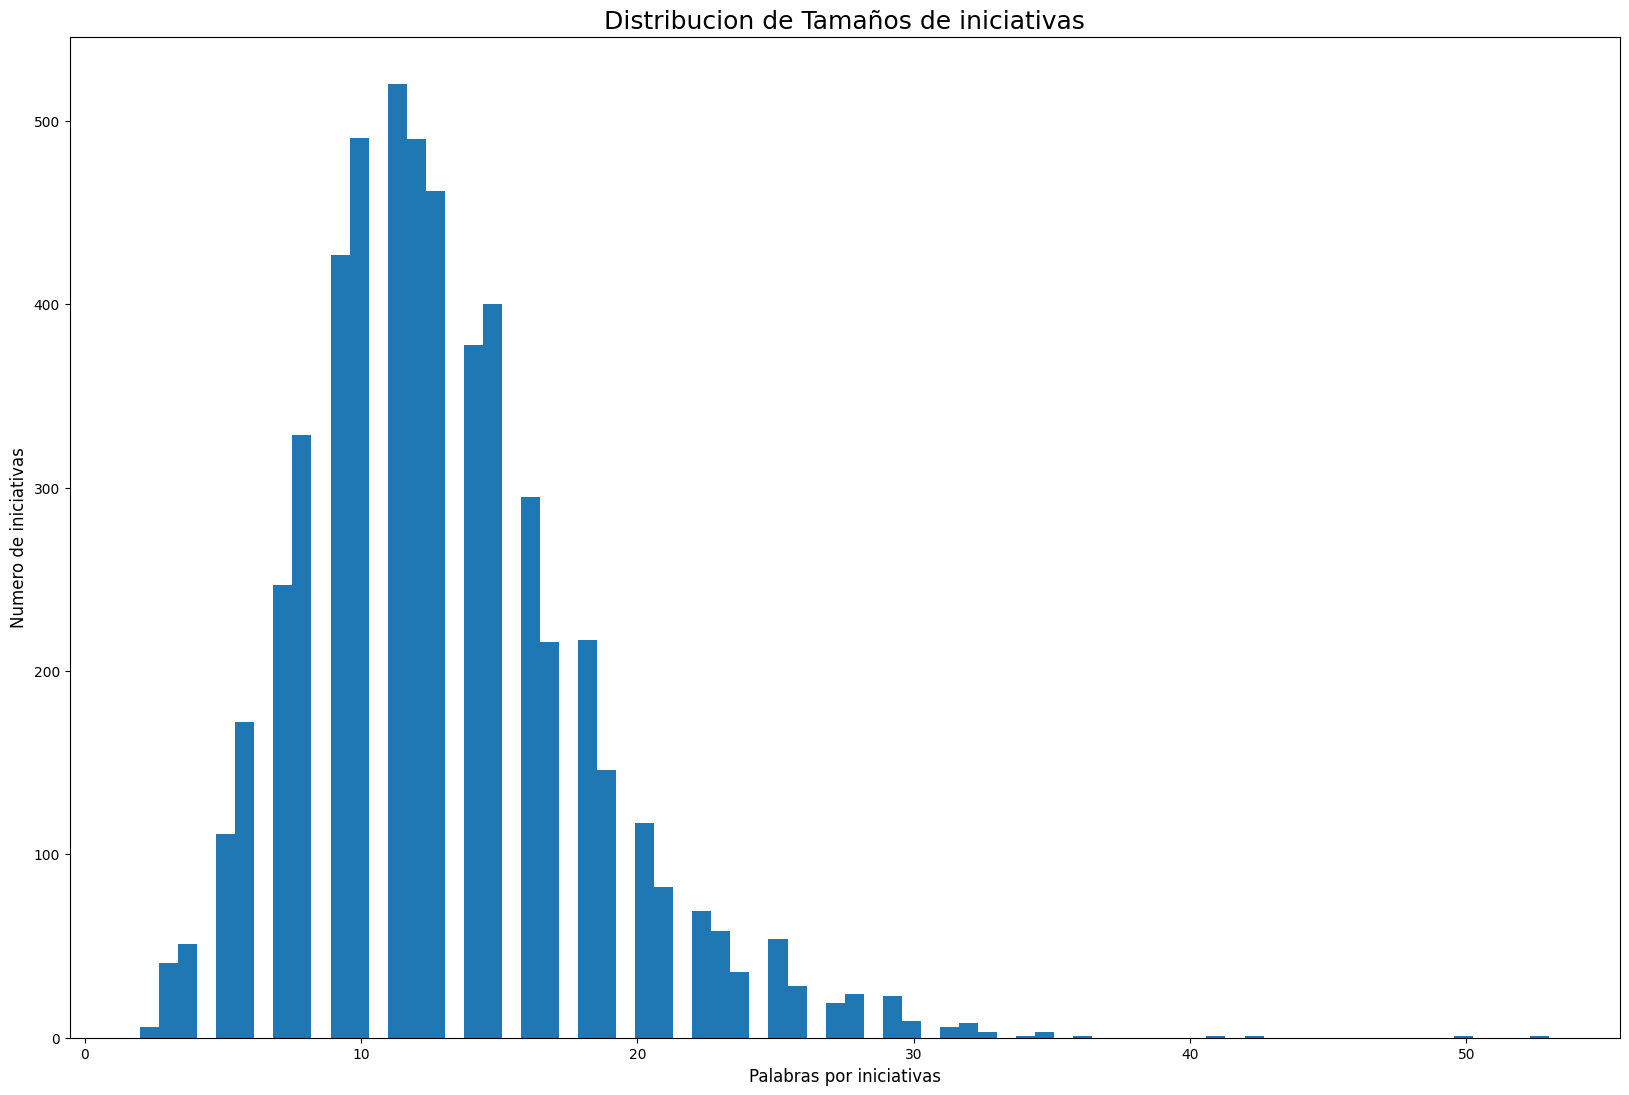

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


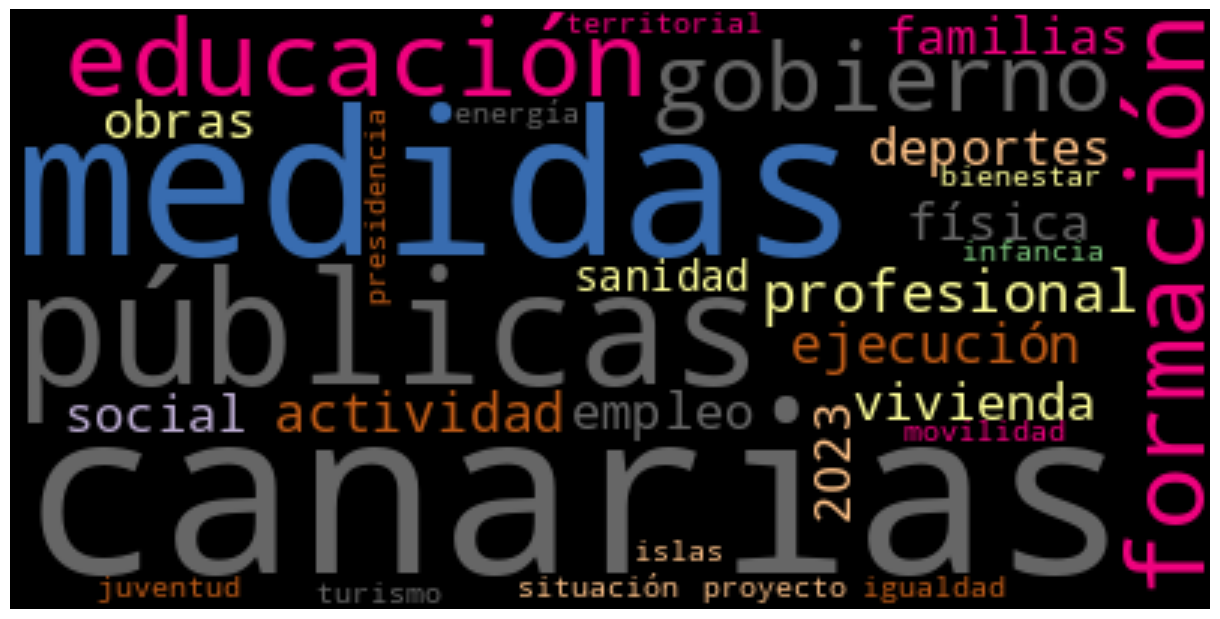

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


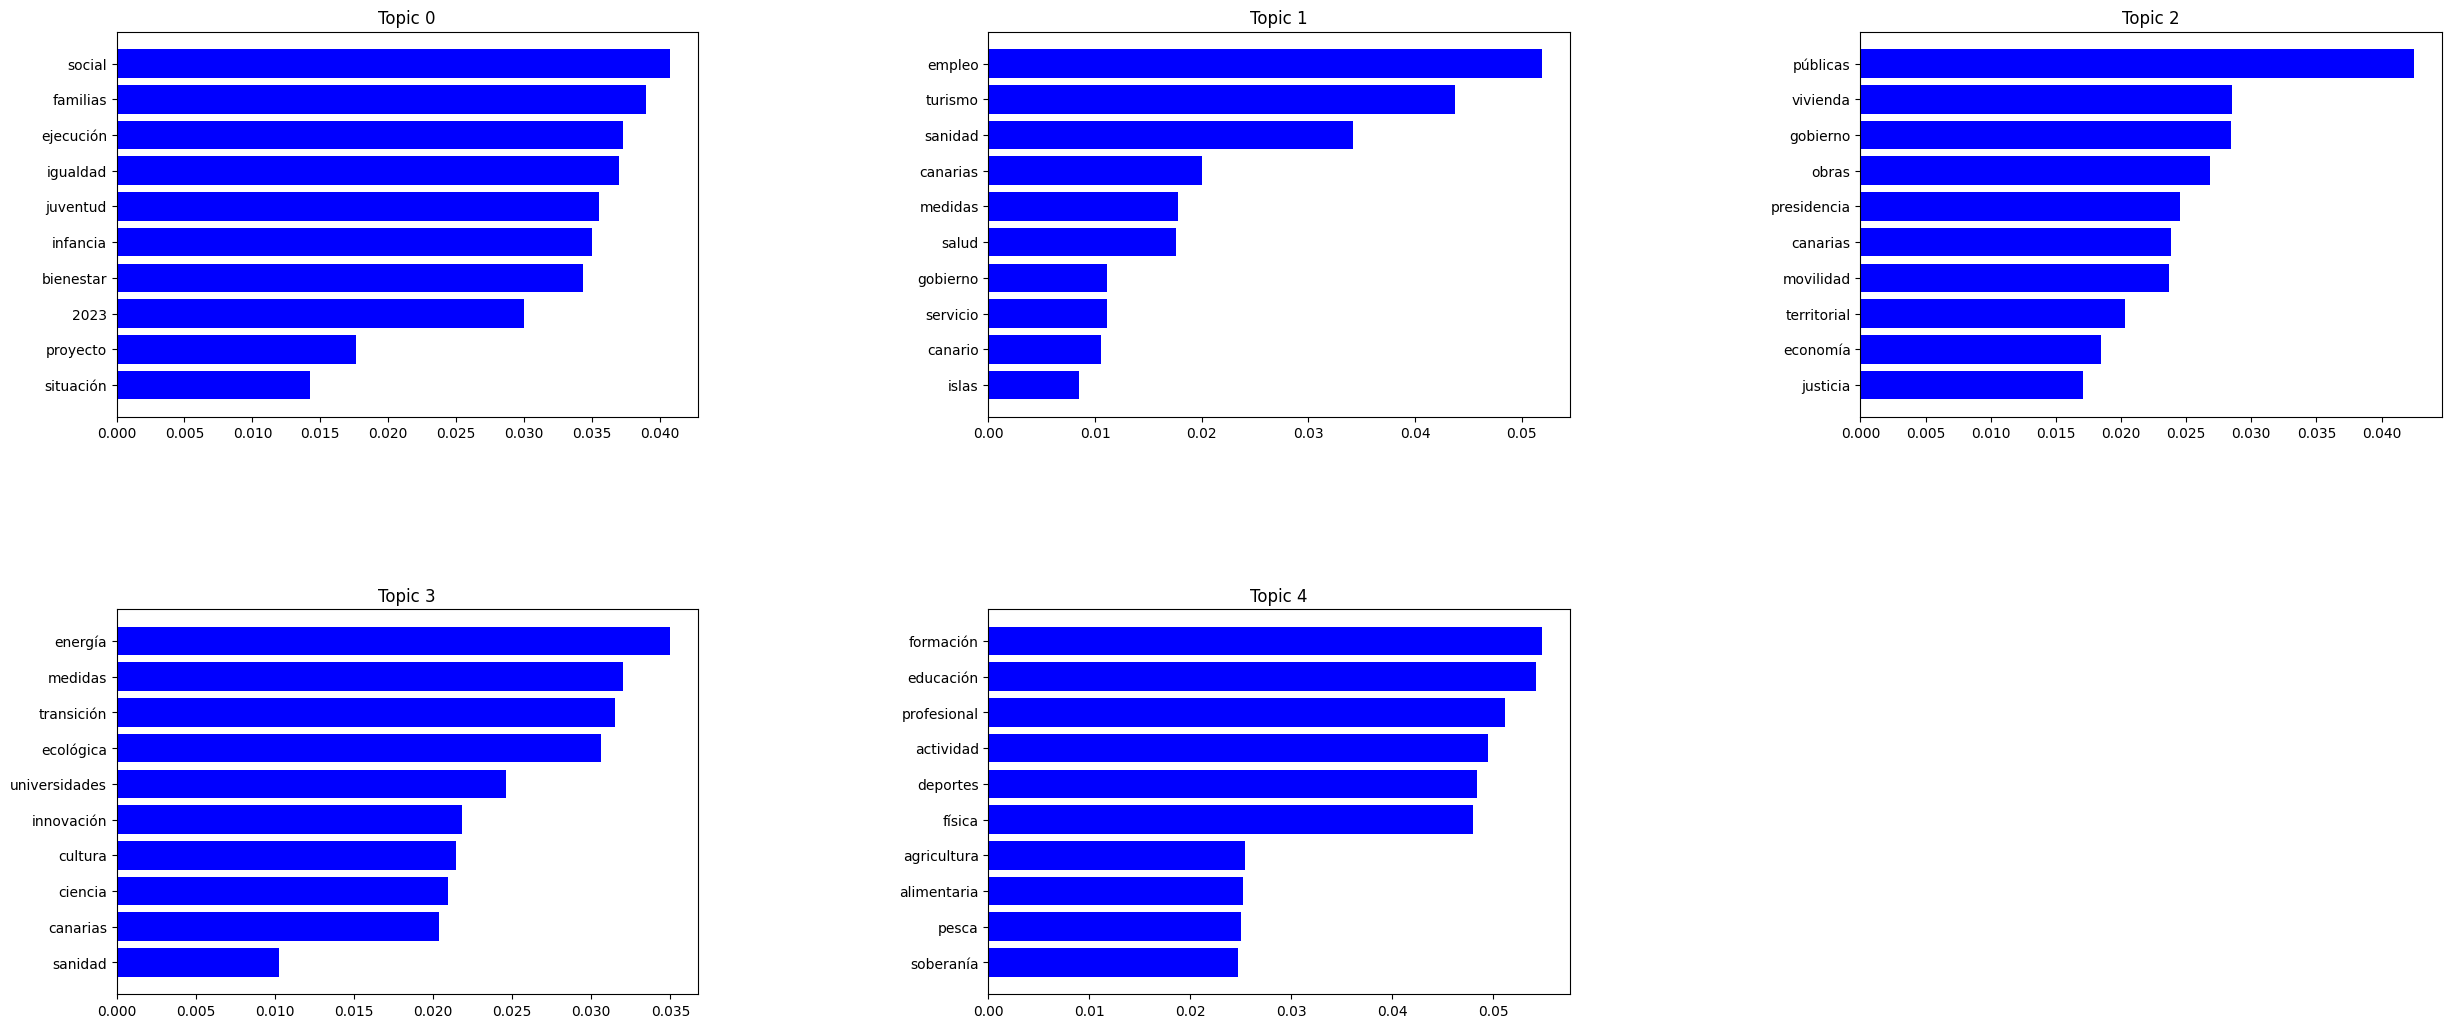

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Graficas del quinto grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token5') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

8415 tokens total, with a vocabulary size of 2415
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


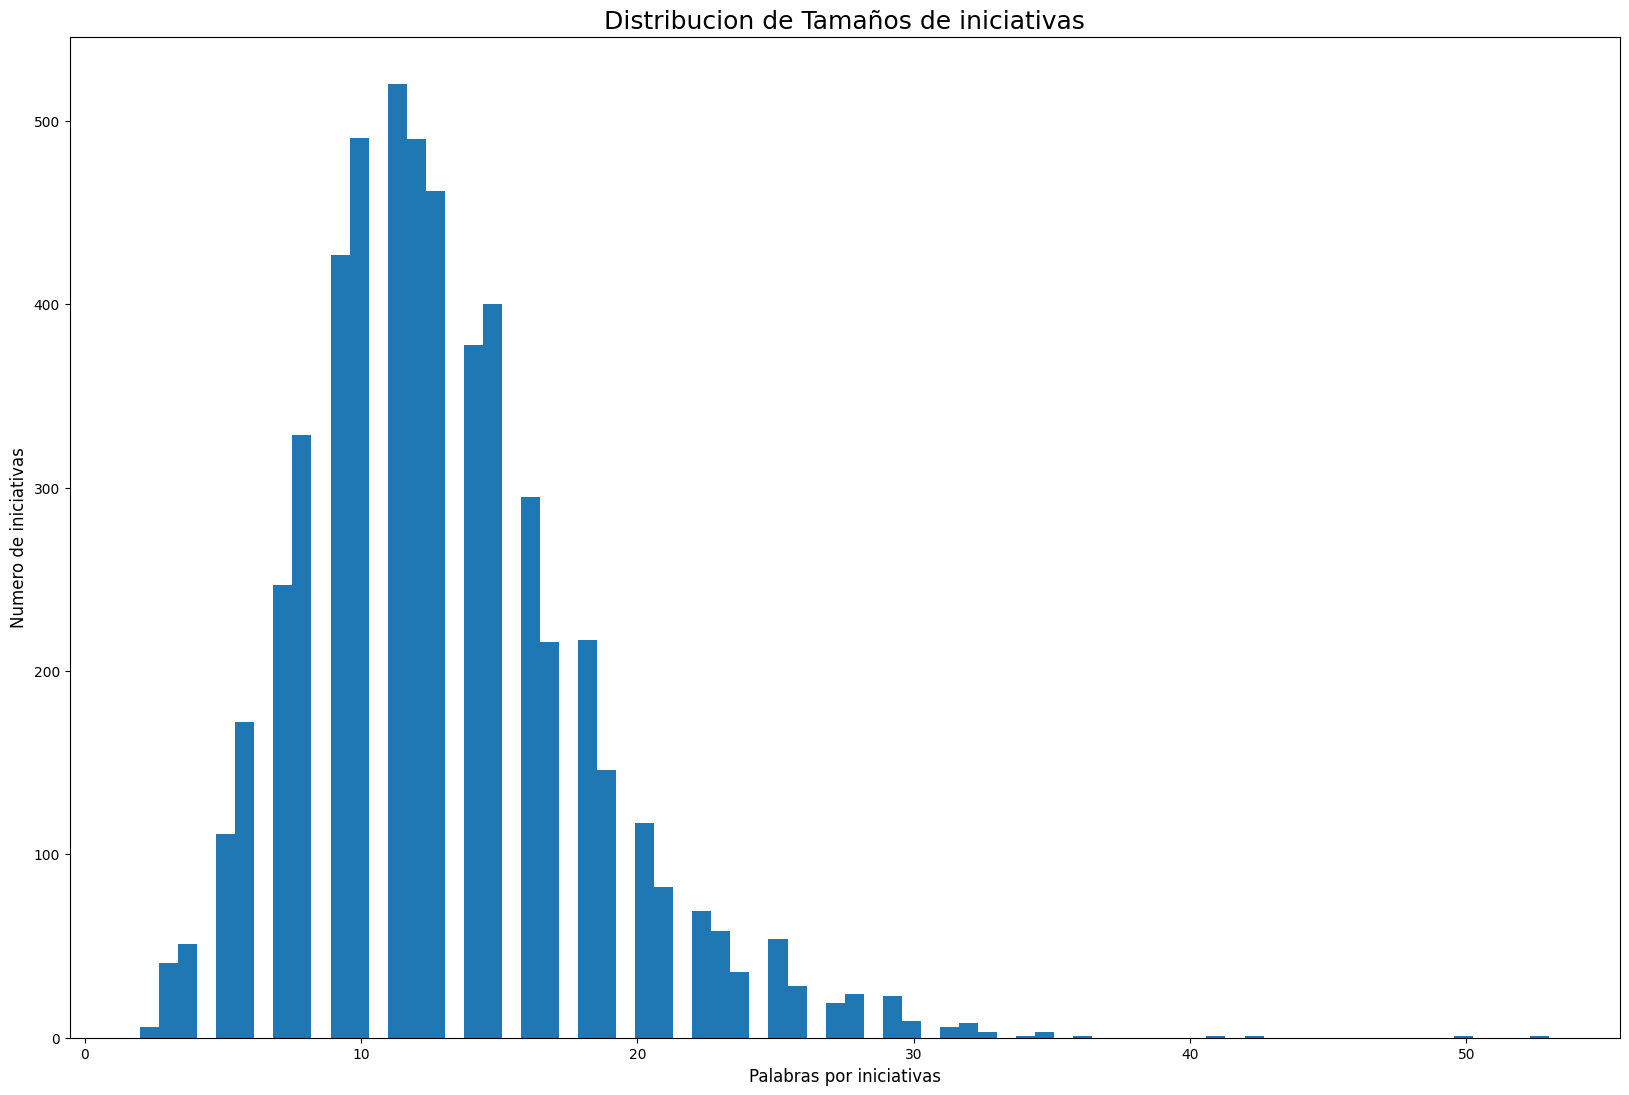

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


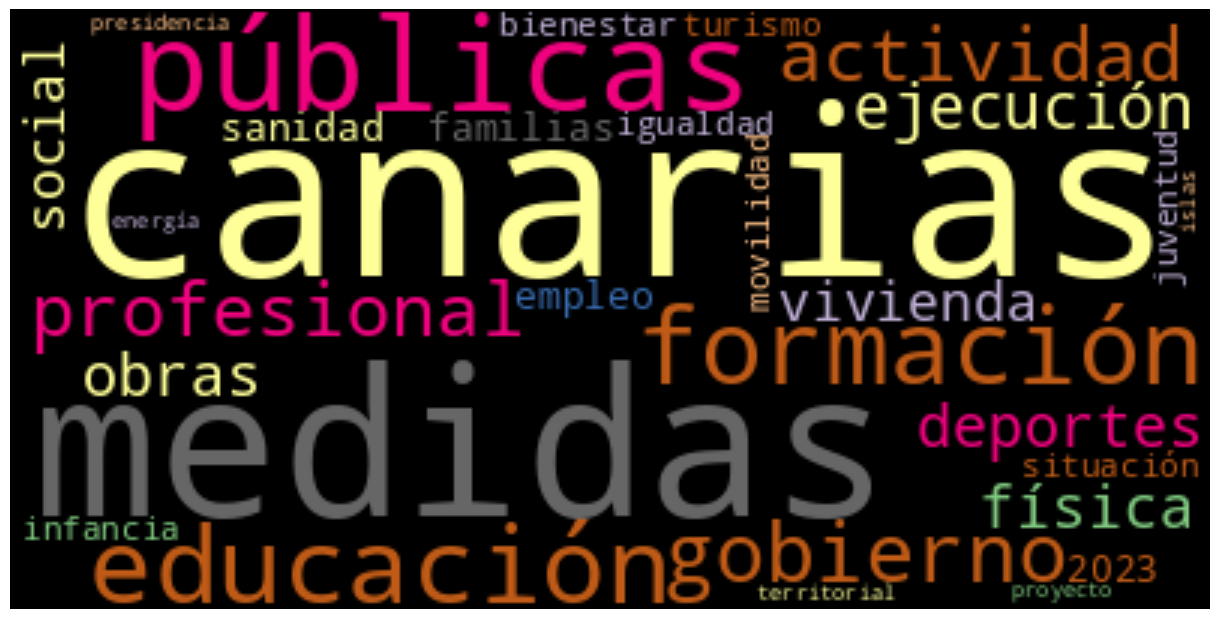

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


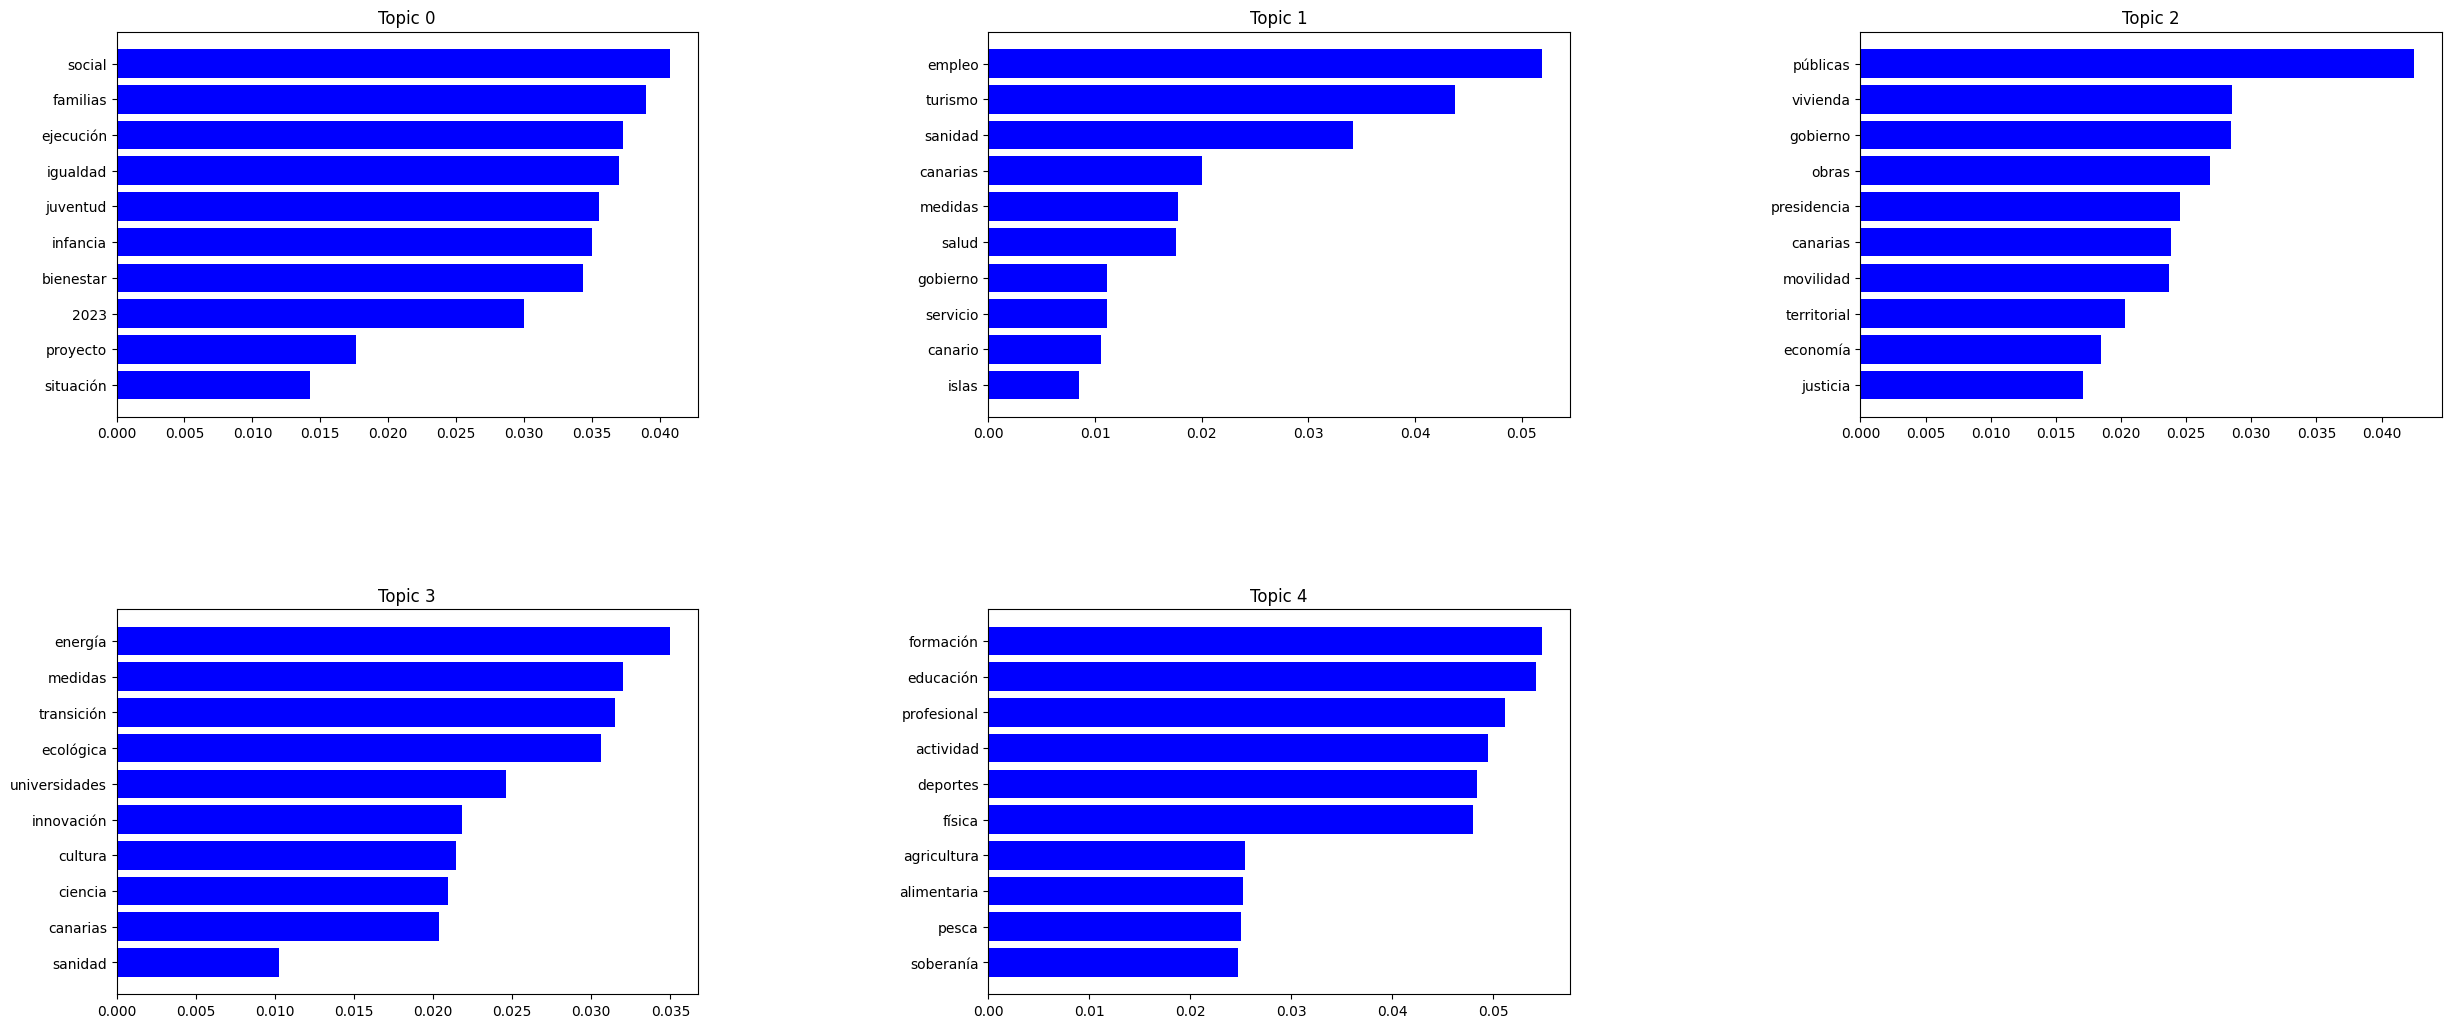

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Graficas del sexto grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token6') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

5042 tokens total, with a vocabulary size of 1536
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


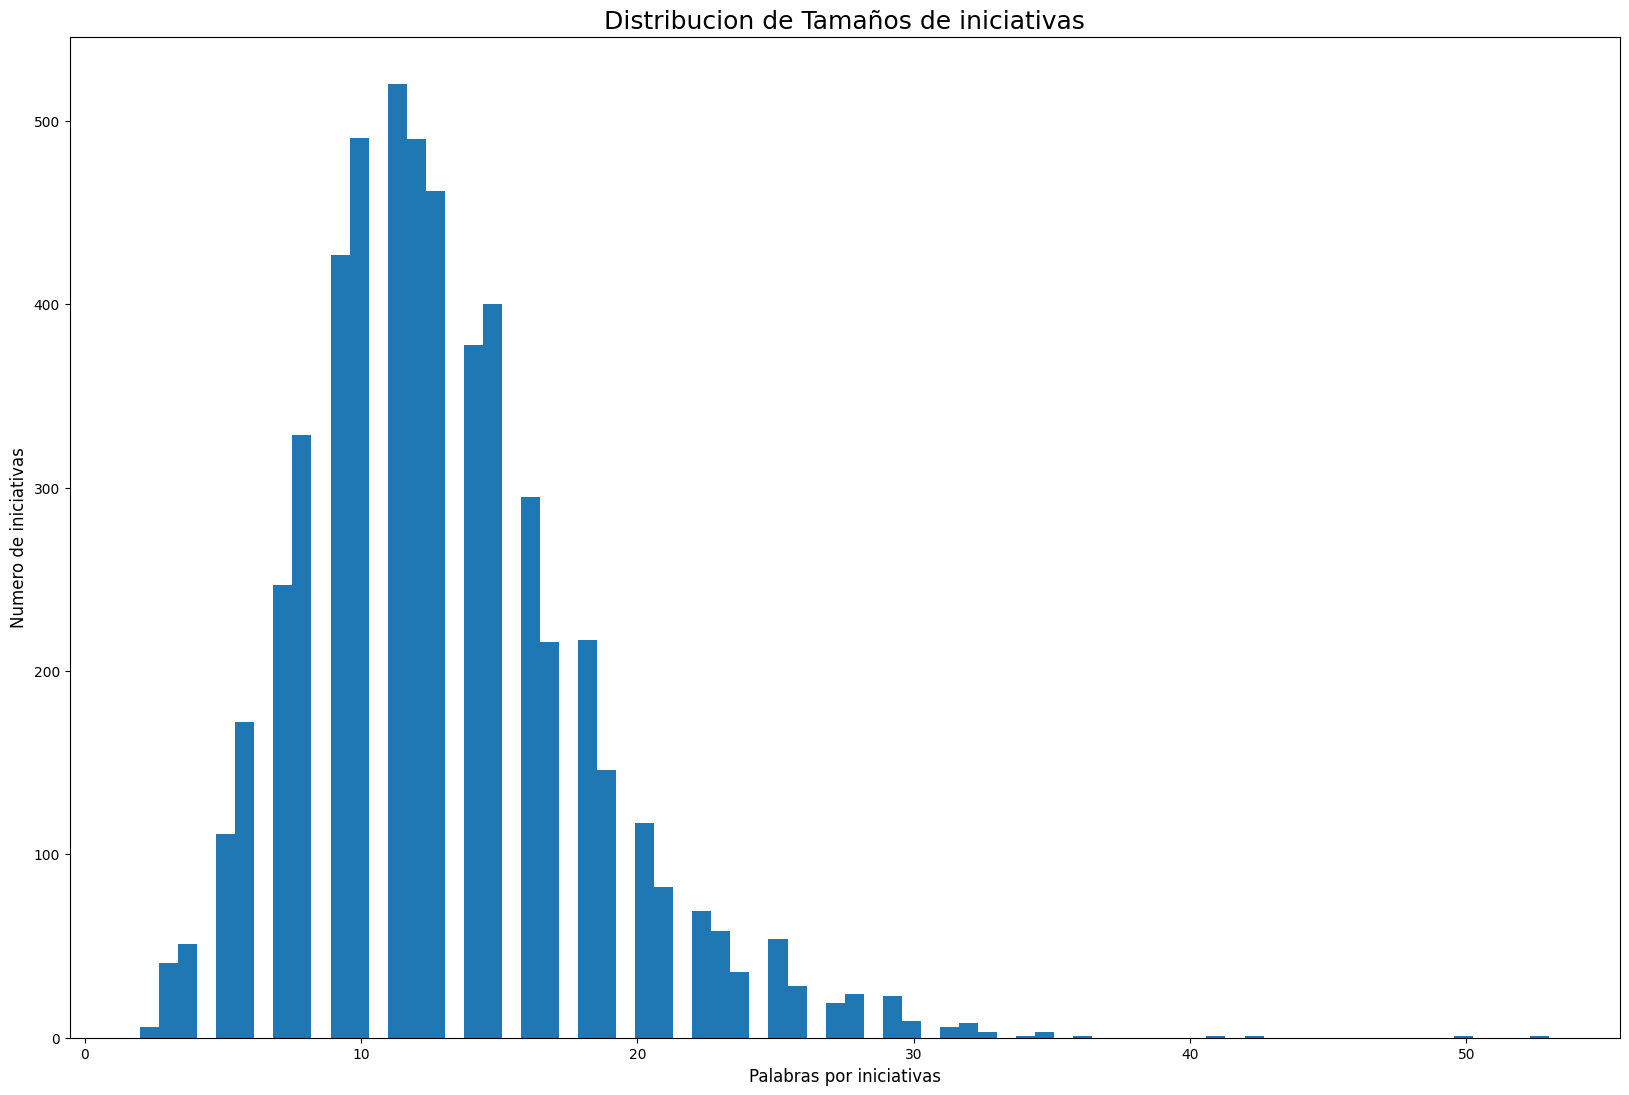

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


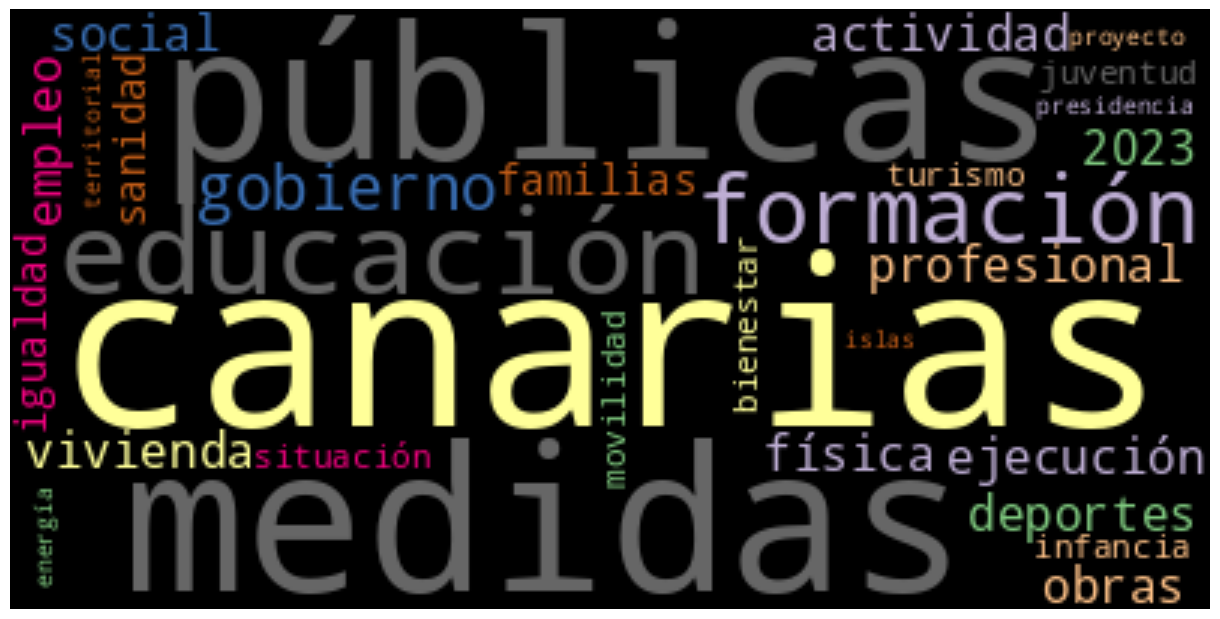

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


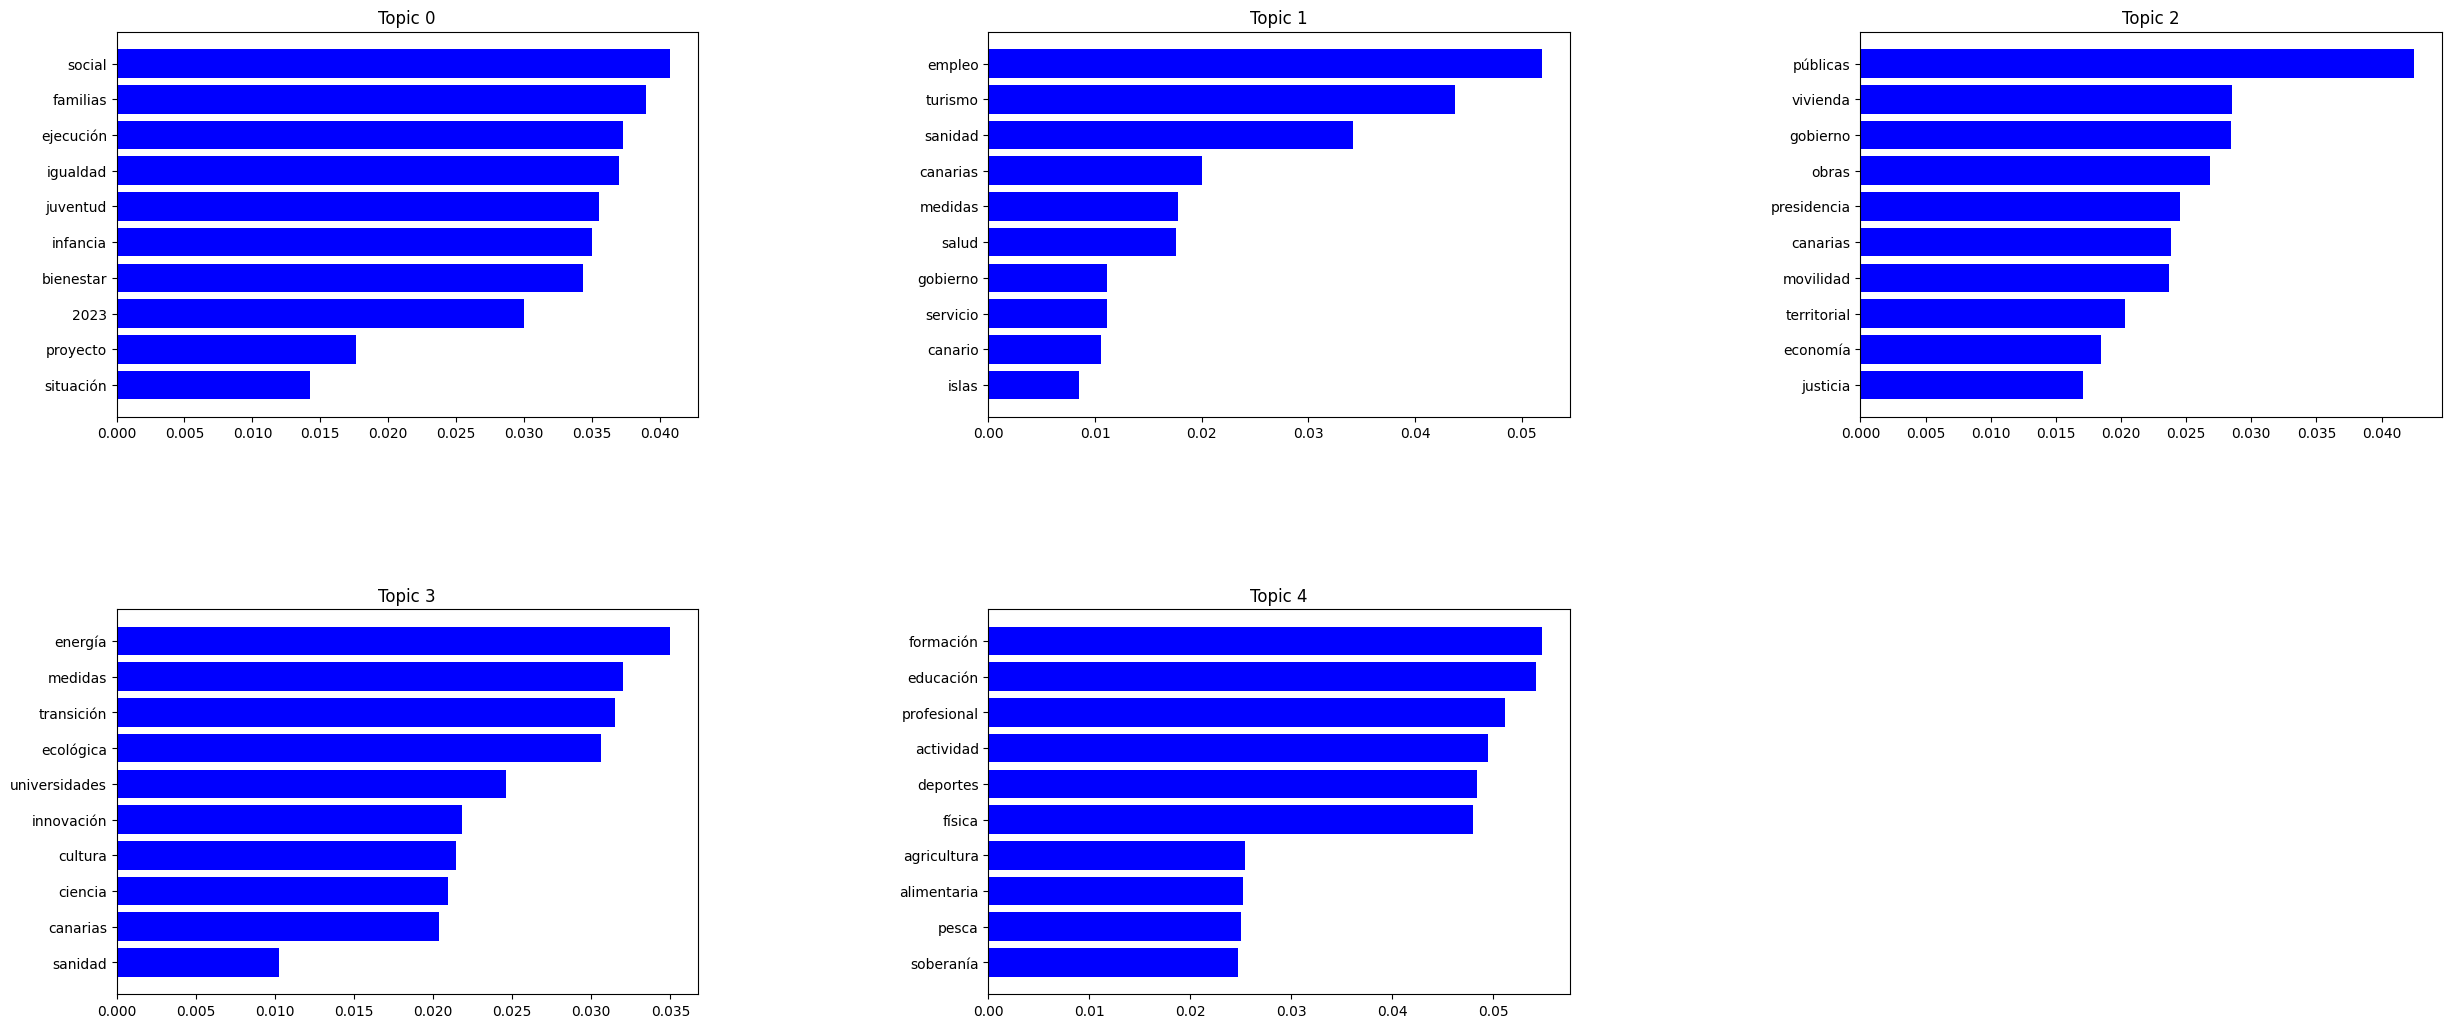

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()

Graficas del septimo grupo

In [ ]:
palabras = [word for tokens in extractos_token.get('extractos_token7') for word in tokens]
extracto_lengths = [len(tokens) for tokens in extracto_token]
vocab = sorted(list(set(palabras)))
print('{} tokens total, with a vocabulary size of {}'.format(len(palabras), len(vocab)))
print('Max tweet length is {}'.format(max(extracto_lengths)))

5064 tokens total, with a vocabulary size of 1617
Max tweet length is 53


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


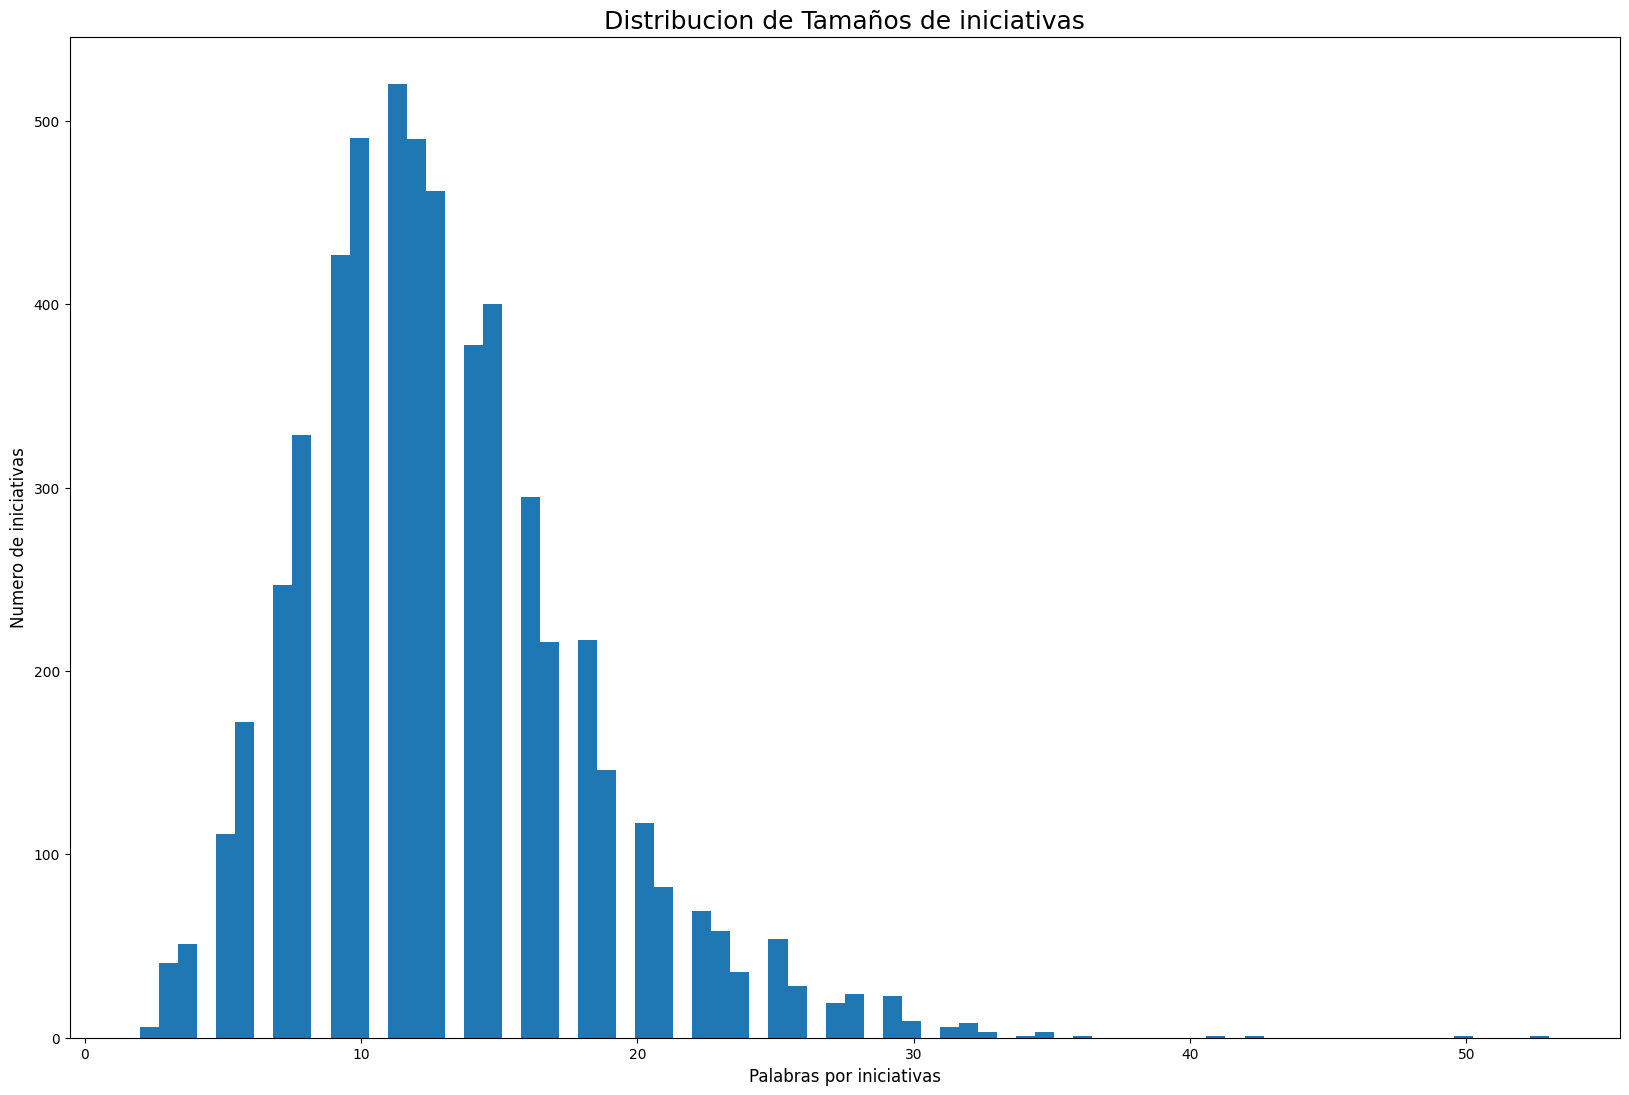

In [ ]:
bins_recomendado = int(math.sqrt(len(extracto_lengths)))
plt.figure(figsize = (20,13))
plt.hist(extracto_lengths, bins=bins_recomendado)
plt.title('Distribucion de Tamaños de iniciativas', fontsize = 18)
plt.xlabel('Palabras por iniciativas', fontsize = 12)
plt.ylabel('Numero de iniciativas', fontsize = 12)
plt.show()

In [ ]:
flat_words = [item for sublist in extracto_token for item in sublist]
word_freq = FreqDist(flat_words)
word_freq.most_common(25)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('canarias', 1127),
 ('medidas', 872),
 ('públicas', 771),
 ('educación', 640),
 ('formación', 639),
 ('gobierno', 594),
 ('profesional', 593),
 ('actividad', 574),
 ('ejecución', 568),
 ('deportes', 556),
 ('física', 551),
 ('obras', 541),
 ('vivienda', 523),
 ('social', 515),
 ('empleo', 512),
 ('2023', 489),
 ('familias', 475),
 ('sanidad', 473),
 ('igualdad', 458),
 ('situación', 452),
 ('juventud', 450),
 ('turismo', 443),
 ('infancia', 440),
 ('bienestar', 432),
 ('movilidad', 427)]

In [ ]:
most_common_count = [x[1] for x in word_freq.most_common(30)]
most_common_word = [x[0] for x in word_freq.most_common(30)]

#create dictionary mapping of word count
top_30_dictionary = dict(zip(most_common_word, most_common_count))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


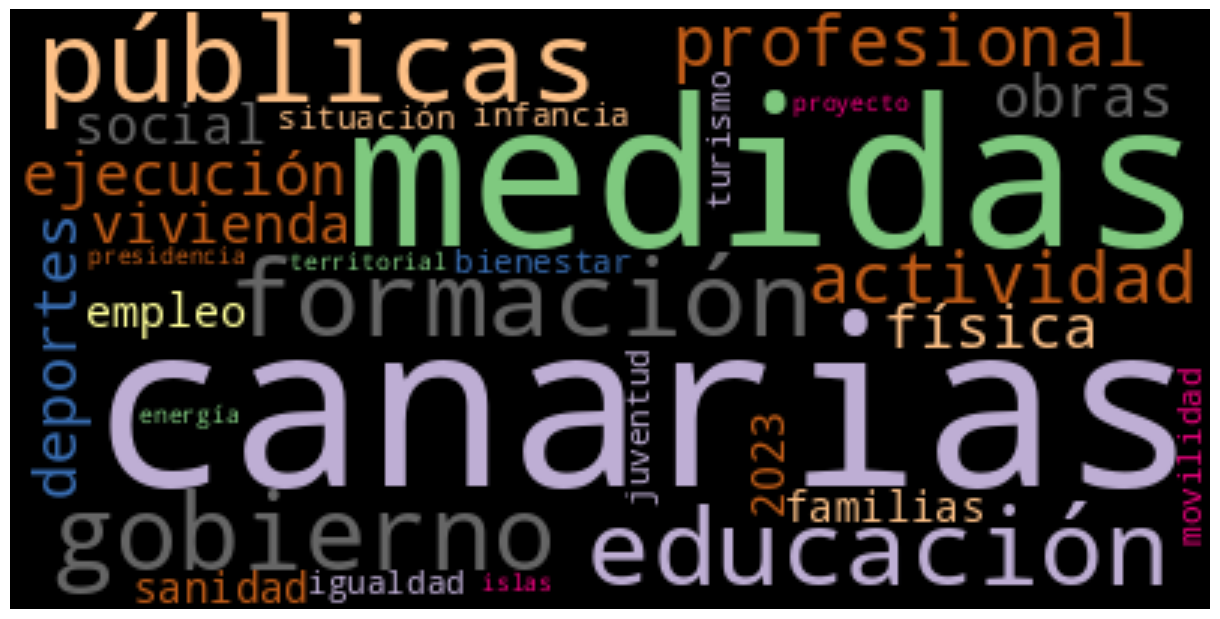

In [ ]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_30_dictionary)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)


plt.show()

In [ ]:
text_dict = Dictionary(extracto_token)
text_dict.filter_extremes(no_below = 5, no_above = .90)
txt_out = text_dict.token2id
extractos_bow = [text_dict.doc2bow(extracto) for extracto in extracto_token]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
k = 5
extractos_lda = LdaModel(extractos_bow,
                      num_topics = k,
                      id2word = text_dict,
                      random_state = 1,
                      passes=10)
extractos_lda.show_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.041*"social" + 0.039*"familias" + 0.037*"ejecución" + 0.037*"igualdad" + 0.036*"juventud" + 0.035*"infancia" + 0.034*"bienestar" + 0.030*"2023" + 0.018*"proyecto" + 0.014*"situación"'),
 (1,
  '0.052*"empleo" + 0.044*"turismo" + 0.034*"sanidad" + 0.020*"canarias" + 0.018*"medidas" + 0.018*"salud" + 0.011*"gobierno" + 0.011*"servicio" + 0.011*"canario" + 0.009*"islas"'),
 (2,
  '0.042*"públicas" + 0.029*"vivienda" + 0.028*"gobierno" + 0.027*"obras" + 0.025*"presidencia" + 0.024*"canarias" + 0.024*"movilidad" + 0.020*"territorial" + 0.018*"economía" + 0.017*"justicia"'),
 (3,
  '0.035*"energía" + 0.032*"medidas" + 0.031*"transición" + 0.031*"ecológica" + 0.025*"universidades" + 0.022*"innovación" + 0.021*"cultura" + 0.021*"ciencia" + 0.020*"canarias" + 0.010*"sanidad"'),
 (4,
  '0.055*"formación" + 0.054*"educación" + 0.051*"profesional" + 0.049*"actividad" + 0.048*"deportes" + 0.048*"física" + 0.025*"agricultura" + 0.025*"alimentaria" + 0.025*"pesca" + 0.025*"soberanía"')]

In [ ]:
def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    extractos_df = pd.DataFrame()
    # Inicializar sent_topics_df como un DataFrame vacío
    sent_topics_df = pd.DataFrame(columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                # Luego, puedes usar el método append
                new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], columns=['Topic_Num', 'Proporción', 'Palabras_Clave'])
                sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)
            else:
                break

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df

df_topic_sents_keywords = format_topics_sentences(ldamodel=extractos_lda, corpus=extractos_bow, texts=extracto_token)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Document_No Dominant_Topic  Topic_Perc_Contrib  \
0            0              4              0.8643   
1            1              0              0.8642   
2            2              1              0.5313   
3            3              4              0.4690   
4            4              1              0.8392   
5            5              3              0.8837   
6            6              1              0.8662   
7            7              3              0.8986   
8            8              4              0.6076   
9            9              2              0.6572   

                                            Keywords  \
0  formación, educación, profesional, actividad, ...   
1  social, familias, ejecución, igualdad, juventu...   
2  empleo, turismo, sanidad, canarias, medidas, s...   
3  formación, educación, profesional, actividad, ...   
4  empleo, turismo, sanidad, canarias, medidas, s...   
5  energía, medidas, transición, ecológica, unive...   
6  empleo, turismo, sanidad, canarias, medidas, s...   
7  energía, medidas, transición, ecológica, unive...   
8  formación, educación, profesional, actividad, ...   
9  públicas, vivienda, gobierno, obras, presidenc...   

                                                Text  
0  [reto, demográfico, equilibrio, poblacional, c...  
1   [revisión, régimen, económico, fiscal, canarias]  
2                        [consejo, canario, cultura]  
3        [grupo, parlamentario, socialista, canario]  
4       [sanidad, líneas, estratégicas, desarrollar]  
5  [transición, ecológica, energía, líneas, estra...  
6  [turismo, empleo, líneas, estratégicas, desarr...  
7  [universidades, ciencia, innovación, cultura, ...  
8  [agricultura, ganadería, pesca, soberanía, ali...  
9  [hacienda, relaciones, unión, europea, líneas,...

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


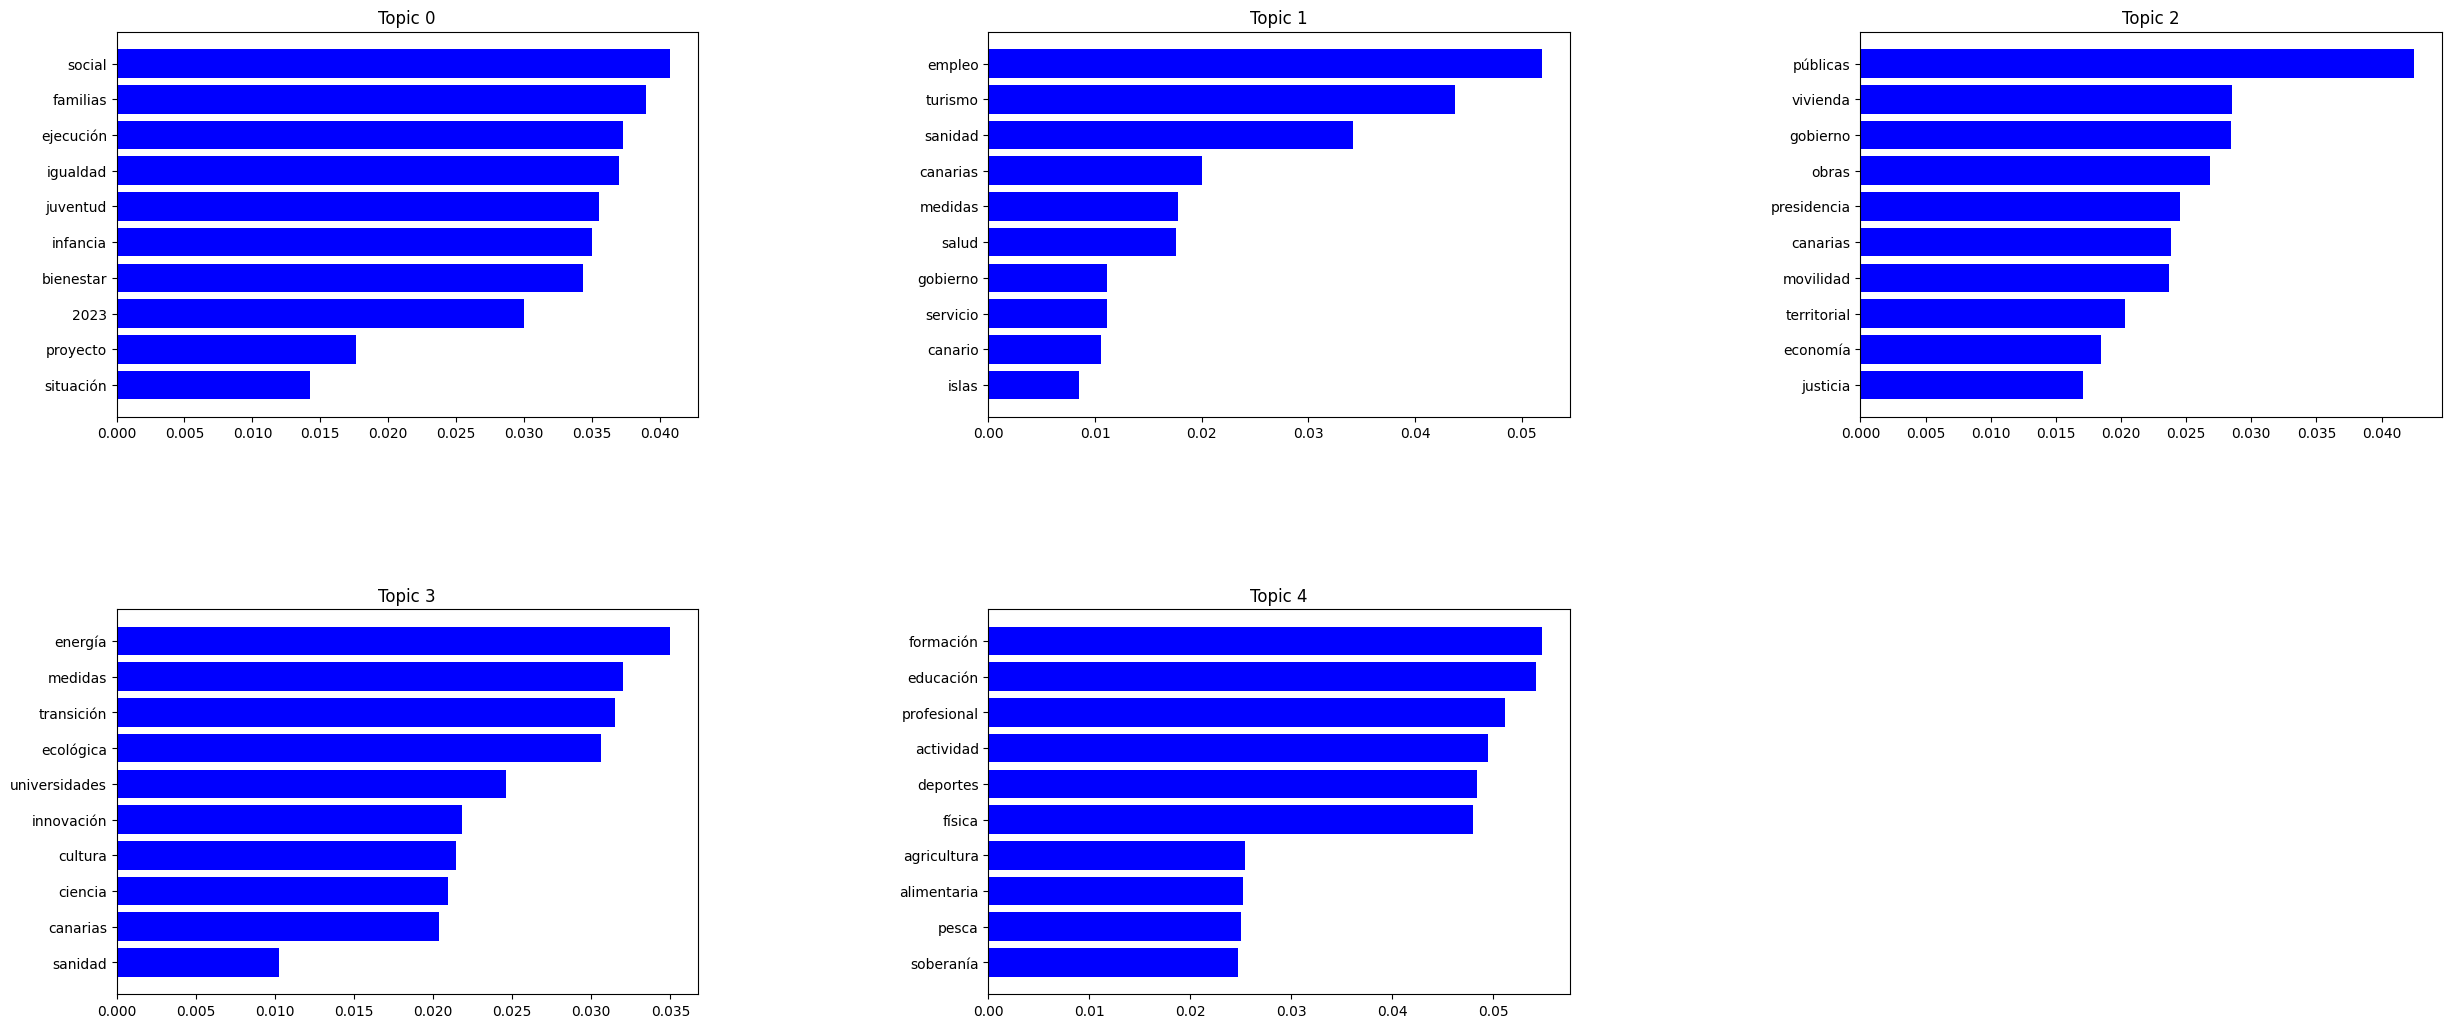

In [ ]:
def plot_top_words(lda=extractos_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=.5, hspace=.5)
    plt.figure(figsize=(30,20))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))

plot_top_words()